The general data calibration strategy is to derive a series of scaling factors or corrections from the calibrators, which are then collectively applied to the science data.

This first stage of data processing in aperture synthesis is to determine the amplitude gain and the phase shift due to each individual antenna.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

## Setup
Parameter definition

In [2]:
msfile='ngc3621.ms'
if not os.path.exists(msfile):
    raise IOError('{} file does not exist.'.format(msfile))

In [3]:
prefix = os.path.splitext(os.path.basename(msfile))[0]
print prefix

ngc3621


In [4]:
tb.open(msfile+'/SOURCE')
source_list = tb.getcol("NAME").tolist()
tb.close()
print('Available sources are {}'.format(source_list))

Available sources are ['0408-65', 'NGC3621', '1117-248']


In [5]:
target='NGC3621'  # Target source
print('Science target {}'.format(target))
phasecal='1117-248'  # Gain (or phase) calibrator
print('Complex gain calibrator {}'.format(phasecal))
bpcal='0408-65'  # Bandpass calibrator
fluxcal='0408-65'  # Flux calibrator
print('Primary or flux calibrator {}'.format(fluxcal))

Science target NGC3621
Complex gain calibrator 1117-248
Primary or flux calibrator 0408-65


In [6]:
tb.open(msfile+'/ANTENNA')
ants_list = tb.getcol("NAME").tolist()
tb.close()
print('Available antennas are {}'.format(ants_list))

Available antennas are ['m003', 'm005', 'm017', 'm018', 'm020', 'm022']


For consistency, specify the reference antenna used when creating the measurement set using the `katdal` script `mvftoms.py`.

In [7]:
ref_ant='m003'  # Reference antenna
if ref_ant not in ants_list:
    raise RuntimeError('{} not an available antenna'.format(ref_ant))
else:
    print('Reference antenna {}'.format(ref_ant))

Reference antenna m003


In [8]:
fixvis(vis=msfile,
       outputvis=prefix+'_fixvis.ms')
msfile = prefix+'_fixvis.ms'

Show log 2019-08-22 14:13:10	INFO	fixvis::::	
 2019-08-22 14:13:10	INFO	fixvis::::+	##########################################
 2019-08-22 14:13:10	INFO	fixvis::::+	##### Begin Task: fixvis #####
 2019-08-22 14:13:10	INFO	fixvis::::	fixvis(vis="ngc3621.ms",outputvis="ngc3621_fixvis.ms",field="",refcode="",reuse=True,
 2019-08-22 14:13:10	INFO	fixvis::::+ phasecenter="",distances="",datacolumn="all")
 2019-08-22 14:13:10	INFO	fixvis::::	Copying original MS to outputvis ...
 2019-08-22 14:13:10	INFO	fixvis::::	Will leave phase centers unchanged.
 2019-08-22 14:13:10	INFO	fixvis::::	Recalculating the UVW coordinates ...
 2019-08-22 14:13:10	INFO	Imager::open() Opening MeasurementSet /home/jupyter/MeerKAT-Cookbook/casa/ngc3621_fixvis.ms
 2019-08-22 14:13:10	INFO	SubMS::parseColumnNames()	Using DATA column.
 2019-08-22 14:13:10	INFO	FixVis::setFields	Selecting fields 0 1 2 
 2019-08-22 14:13:10	INFO	FixVis::calc_uvw	The UVWs are already in the desired frame - leaving them as is.
 2019-08-22 14:13:10	INFO	fixvis::::	CASA Version 5.5.0-149 
 2019-08-22 14:13:10	INFO	fixvis::::	
 2019-08-22 14:13:10	INFO	fixvis::::	##### End Task: fixvis #####
 2019-08-22 14:13:10	INFO	fixvis::::+	##########################################

## Calibrations
Start by re-initializes calibrated visibility data in a given MS and create all the columns and tables for the measurement set    
Setup parameters and remove previous calibration solutions
clearcal(msfile)

In [9]:
clearstat()
clearcal(msfile)

Show log 2019-08-22 14:13:12	INFO	clearstat::::	
 2019-08-22 14:13:12	INFO	clearstat::::+	##########################################
 2019-08-22 14:13:12	INFO	clearstat::::+	##### Begin Task: clearstat #####
 2019-08-22 14:13:12	INFO	clearstat::::	
 2019-08-22 14:13:12	INFO	clearstat::::	##### End Task: clearstat #####
 2019-08-22 14:13:12	INFO	clearstat::::+	##########################################
 2019-08-22 14:13:12	INFO	clearcal::::	
 2019-08-22 14:13:12	INFO	clearcal::::+	##########################################
 2019-08-22 14:13:12	INFO	clearcal::::+	##### Begin Task: clearcal #####
 2019-08-22 14:13:12	INFO	clearcal::::	clearcal(vis="ngc3621_fixvis.ms",field="",spw="",intent="",addmodel=False)
 2019-08-22 14:13:12	INFO	clearcal::::	Need to create scratch columns; ignoring selection.
 2019-08-22 14:13:12	WARN	calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
 2019-08-22 14:13:12	INFO	calibrater::open	****Using OLD VI-driven calibrater tool****
 2019-08-22 14:13:12	INFO	calibrater::open	Opening MS: ngc3621_fixvis.ms for calibration.
 2019-08-22 14:13:12	INFO	VisSetUtil::addScrCols	Adding CORRECTED_DATA column(s).
 2019-08-22 14:13:12	INFO	VisSetUtil::addScrCols	Start copying column keyword(s) of CORRECTED_DATA from DATA
 2019-08-22 14:13:12	INFO	Calibrater::	Initializing nominal selection to the whole MS.
 2019-08-22 14:13:12	INFO	clearcal::::	CASA Version 5.5.0-149 
 2019-08-22 14:13:12	INFO	clearcal::::	
 2019-08-22 14:13:12	INFO	clearcal::::	##### End Task: clearcal #####
 2019-08-22 14:13:12	INFO	clearcal::::+	##########################################

####  Setting fluxes on flux calibrator
Setting the flux to -1 causes `setjy` to look up the flux density.    
MeerKAT standard flux calibrators can be found in [Standard flux calibrators](https://github.com/ska-sa/MeerKAT-Cookbook/blob/master/casa/Standard%20flux%20calibrators.ipynb)

The strategy is to have model visibilities in the MODEL  column, and gaincal divides DATA by MODEL. (In other  words: gaincal assumes a 1Jy point source.). Thus, setjy is used to fill in the MODEL column.

In [10]:
log_S = -0.9790 + 3.3662*np.log10(1284.) -1.1216*np.log10(1284.)**2 + 0.0861*np.log10(1284.)**3
setjy(vis=msfile, field=fluxcal, scalebychan=True, standard='manual', fluxdensity=[10**log_S,0,0,0])

{'0': {'0': {'fluxd': array([ 17.10634985,   0.        ,   0.        ,   0.        ])},
  'fieldName': '0408-65'},
 'format': "{field Id: {spw Id: {fluxd: [I,Q,U,V] in Jy}, 'fieldName':field name }}"}

Show log 2019-08-22 14:13:15	INFO	setjy::::	
 2019-08-22 14:13:15	INFO	setjy::::+	##########################################
 2019-08-22 14:13:15	INFO	setjy::::+	##### Begin Task: setjy #####
 2019-08-22 14:13:15	INFO	setjy::::	setjy(vis="ngc3621_fixvis.ms",field="0408-65",spw="",selectdata=False,timerange="",
 2019-08-22 14:13:15	INFO	setjy::::+ scan="",intent="",observation="",scalebychan=True,standard="manual",
 2019-08-22 14:13:15	INFO	setjy::::+ model="",modimage="",listmodels=False,fluxdensity=[17.106349850349627, 0, 0, 0],spix=0.0,
 2019-08-22 14:13:15	INFO	setjy::::+ reffreq="1GHz",polindex=[],polangle=[],rotmeas=0.0,fluxdict={},
 2019-08-22 14:13:15	INFO	setjy::::+ useephemdir=False,interpolation="nearest",usescratch=False,ismms=False)
 2019-08-22 14:13:15	INFO	setjy::::	{'field': '0408-65'}
 2019-08-22 14:13:15	INFO	Imager::open() Opening MeasurementSet /home/jupyter/MeerKAT-Cookbook/casa/ngc3621_fixvis.ms
 2019-08-22 14:13:15	INFO	setjy::::	CASA Version 5.5.0-149 
 2019-08-22 14:13:15	INFO	setjy::::	
 2019-08-22 14:13:15	INFO	imager::setjy()	The applied flux density does not depend on frequency.
 2019-08-22 14:13:15	INFO	imager::data selection	Selected 3129 out of 15687 rows.
 2019-08-22 14:13:15	INFO	imager::setjy()	Will clear any existing model with matching field=0408-65 and spw=*
 2019-08-22 14:13:15	INFO Clearing model records in MS header for selected fields.
 2019-08-22 14:13:15	INFO 0408-65 (id = 0) not found.
 2019-08-22 14:13:15	INFO	imager::data selection	Selected 3129 out of 15687 rows.
 2019-08-22 14:13:15	INFO	imager::ft() Fourier transforming: replacing visibility model header
 2019-08-22 14:13:15	INFO	imager::createSkyEquation() Processing after subtracting componentlist /home/jupyter/MeerKAT-Cookbook/casa/ngc3621_fixvis.ms_setjy_spw0_0408-65_1GHz57851.6d.cl
 2019-08-22 14:13:15	INFO	imager::createFTMachine() Performing interferometric gridding...
 2019-08-22 14:13:15	INFO	setjy::::	##### End Task: setjy #####
 2019-08-22 14:13:15	INFO	setjy::::+	##########################################

#### Preliminary phase calibration
While amplitude variations with time will have little effect on the bandpass solutions, it is important to solve for phase variations with time to prevent de-correlation when vector averaging the data for computing the final bandpass solution.   
To stabilize time varying components, do a basic phase calibration using a selection of channels near the center of the frequency band that are relatively free from interference.

Perform phase-only gain calibration to correct phases on the bandpass calibrator.   
To take out the major phase variations over time, start by determining an initial phase solution for the bandpass calibrator.   
For maximum sensitivity, average all the spw together, with the exception of SPWs which show large phase offsets in the phase vs. channel plot.

To identify these channels use the plotms viewer as previously:
```
plotms(vis=msfile, xaxis='channel', yaxis='phase', correlation='XX,YY', scan='28', field='PKS1934-638', iteraxis='baseline', coloraxis='corr', plotrange=[0,0,-180,180])
```

`gaincal` provide antenna-based components which can be inspected for each antenna using `plotcal`
```
plotcal(caltable = gtable0, field=b_cal, xaxis = 'time', yaxis = 'phase', iteration='antenna', subplot=321)
```

In [11]:
gtable0 = prefix + '.G0'
rmtables(gtable0)

Show log 2019-08-22 14:13:19	INFO	rmtables::::	
 2019-08-22 14:13:19	INFO	rmtables::::+	##########################################
 2019-08-22 14:13:19	INFO	rmtables::::+	##### Begin Task: rmtables #####
 2019-08-22 14:13:19	INFO	rmtables::::	rmtables(tablenames="ngc3621.G0")
 2019-08-22 14:13:19	WARN	rmtables::utils::removetable	Empty filename
 2019-08-22 14:13:19	WARN	rmtables::utils::removetable	Cannot delete file because it's not a table.
 2019-08-22 14:13:19	INFO	rmtables::::	##### End Task: rmtables #####
 2019-08-22 14:13:19	INFO	rmtables::::+	##########################################

Calculate temporary phase-calibration, `gaincal` on the bandpass calibrator to determine phase-only gain solutions. 

We will use `solint='int'` for the solution interval, which means that one gain solution will be determined for every integration time. This short integration time is possible because the bandpass calibrator is a very bright point source, so we have very high signal-to-noise (SNR) and a perfect model. This will correct for any phase variations in the bandpass calibrator as a function of time, a step which will prevent decorrelation of the vector-averaged bandpass solutions. We will then apply these solutions on-the-fly when we run bandpass.

In [12]:
gaincal(vis=msfile,
        caltable=gtable0,
        field=fluxcal,
        solint='int',
        refant=ref_ant,
        minblperant=4,
        gaintype='G',
        calmode='p',
        minsnr=3.0,
        gaintable=[''],
        )

Show log 2019-08-22 14:13:22	INFO	gaincal::::	
 2019-08-22 14:13:22	INFO	gaincal::::+	##########################################
 2019-08-22 14:13:22	INFO	gaincal::::+	##### Begin Task: gaincal #####
 2019-08-22 14:13:22	INFO	gaincal::::	gaincal(vis="ngc3621_fixvis.ms",caltable="ngc3621.G0",field="0408-65",spw="",intent="",
 2019-08-22 14:13:22	INFO	gaincal::::+ selectdata=True,timerange="",uvrange="",antenna="",scan="",
 2019-08-22 14:13:22	INFO	gaincal::::+ observation="",msselect="",solint="int",combine="",preavg=-1.0,
 2019-08-22 14:13:22	INFO	gaincal::::+ refant="m003",refantmode="flex",minblperant=4,minsnr=3.0,solnorm=False,
 2019-08-22 14:13:22	INFO	gaincal::::+ normtype="mean",gaintype="G",smodel=[],calmode="p",solmode="",
 2019-08-22 14:13:22	INFO	gaincal::::+ rmsthresh=[],append=False,splinetime=3600.0,npointaver=3,phasewrap=180.0,
 2019-08-22 14:13:22	INFO	gaincal::::+ docallib=False,callib="",gaintable=[''],gainfield=[''],interp=[],
 2019-08-22 14:13:22	INFO	gaincal::::+ spwmap=[],parang=False)
 2019-08-22 14:13:22	INFO	gaincal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-08-22 14:13:22	INFO	gaincal::calibrater::open	Opening MS: ngc3621_fixvis.ms for calibration.
 2019-08-22 14:13:22	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2019-08-22 14:13:22	INFO	gaincal::::	NB: gaincal automatically excludes auto-correlations.
 2019-08-22 14:13:22	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-08-22 14:13:22	INFO	calibrater::reset	Reseting solve/apply state
 2019-08-22 14:13:22	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2019-08-22 14:13:22	INFO	Calibrater::selectvis+ Selecting on field: '0408-65'
 2019-08-22 14:13:22	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2019-08-22 14:13:22	INFO	Calibrater::selectvis	By selection 15687 rows are reduced to 2235
 2019-08-22 14:13:22	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2019-08-22 14:13:22	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2019-08-22 14:13:22	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2019-08-22 14:13:22	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2019-08-22 14:13:22	INFO	Calibrater::setsolve	. G Jones: table=ngc3621.G0 append=false solint=int refantmode='flex' refant='m003' minsnr=3 apmode=P solnorm=false
 2019-08-22 14:13:22	INFO	calibrater::solve	Beginning solve-----------------------------
 2019-08-22 14:13:22	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2019-08-22 14:13:22	INFO	Calibrater::solve	. (None)
 2019-08-22 14:13:22	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2019-08-22 14:13:22	INFO	Calibrater::solve	. G Jones: table=ngc3621.G0 append=false solint=int refantmode='flex' refant='m003' minsnr=3 apmode=P solnorm=false
 2019-08-22 14:13:22	INFO	ChannelAverageTVI::parseConfiguration	Channel bin is [-1]
 2019-08-22 14:13:22	INFO	Calibrater::solve	For solint = int, found 149 solution intervals.
 2019-08-22 14:13:23	INFO	Calibrater::solve Found good G Jones solutions in 149 solution intervals.
 2019-08-22 14:13:23	INFO Applying refant: m003 refantmode = flex (hold alternate refants' phase constant) when refant flagged
 2019-08-22 14:13:23	INFO Enforcing apmode on solutions.
 2019-08-22 14:13:23	INFO Writing solutions to table: ngc3621.G0
 2019-08-22 14:13:24	INFO	calibrater::solve	Finished solving.
 2019-08-22 14:13:24	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2019-08-22 14:13:24	INFO	gaincal:::: Spw 0: 149/149/149
 2019-08-22 14:13:24	INFO	gaincal::::	##### End Task: gaincal #####
 2019-08-22 14:13:24	INFO	gaincal::::+	##########################################

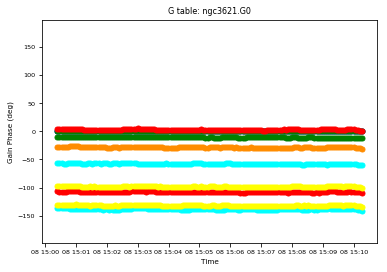

Show log 2019-08-22 14:13:28	INFO	plotcal::::	
 2019-08-22 14:13:28	INFO	plotcal::::+	##########################################
 2019-08-22 14:13:28	INFO	plotcal::::+	##### Begin Task: plotcal #####
 2019-08-22 14:13:28	INFO	plotcal::::	plotcal(caltable="ngc3621.G0",xaxis="time",yaxis="phase",poln="",field="0408-65",
 2019-08-22 14:13:28	INFO	plotcal::::+ antenna="",spw="0",timerange="",subplot=111,overplot=True,
 2019-08-22 14:13:28	INFO	plotcal::::+ clearpanel="Auto",iteration="",plotrange=[-1, -1, -180, 180],showflags=False,plotsymbol="o",
 2019-08-22 14:13:28	INFO	plotcal::::+ plotcolor="blue",markersize=5.0,fontsize=8,showgui=True,figfile="")
 2019-08-22 14:13:28	INFO	tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2019-08-22 14:13:28	INFO	plotcal::createCalTab Detected a NewCalTable!
 2019-08-22 14:13:28	INFO Now get the data
 2019-08-22 14:13:28	INFO Done Processing data ... 
 2019-08-22 14:13:29	INFO	plotcal::::	##### End Task: plotcal #####
 2019-08-22 14:13:29	INFO	plotcal::::+	##########################################

In [14]:
plotcal(caltable=gtable0,
        xaxis='time', yaxis='phase',
        field=fluxcal, spw='0',
        plotrange = [-1, -1, -180, 180], fontsize=8, overplot=True,
        )

####  Solving for delays

The first stage of bandpass calibration involves solving for the antenna-based delays which put a phase ramp versus frequency channel in each spectral window.    
The K gain type in gaincal solves for the relative delays of each antenna relative to the reference antenna.

In [15]:
ktable = prefix + '.K'
rmtables(ktable)

Show log 2019-08-22 14:13:35	INFO	rmtables::::	
 2019-08-22 14:13:35	INFO	rmtables::::+	##########################################
 2019-08-22 14:13:35	INFO	rmtables::::+	##### Begin Task: rmtables #####
 2019-08-22 14:13:35	INFO	rmtables::::	rmtables(tablenames="ngc3621.K")
 2019-08-22 14:13:35	WARN	rmtables::utils::removetable	Empty filename
 2019-08-22 14:13:35	WARN	rmtables::utils::removetable	Cannot delete file because it's not a table.
 2019-08-22 14:13:35	INFO	rmtables::::	##### End Task: rmtables #####
 2019-08-22 14:13:35	INFO	rmtables::::+	##########################################

In [16]:
gaincal(vis=msfile,
        caltable=ktable,
        field=fluxcal,
        gaintype='K',
        solint='inf',
        refant=ref_ant,
        combine='scan',
        minblperant=4,
        solnorm=False,
        minsnr=3.0,
        gaintable=[gtable0],
        )    

Show log 2019-08-22 14:13:38	INFO	gaincal::::	
 2019-08-22 14:13:38	INFO	gaincal::::+	##########################################
 2019-08-22 14:13:38	INFO	gaincal::::+	##### Begin Task: gaincal #####
 2019-08-22 14:13:38	INFO	gaincal::::	gaincal(vis="ngc3621_fixvis.ms",caltable="ngc3621.K",field="0408-65",spw="",intent="",
 2019-08-22 14:13:38	INFO	gaincal::::+ selectdata=True,timerange="",uvrange="",antenna="",scan="",
 2019-08-22 14:13:38	INFO	gaincal::::+ observation="",msselect="",solint="inf",combine="scan",preavg=-1.0,
 2019-08-22 14:13:38	INFO	gaincal::::+ refant="m003",refantmode="flex",minblperant=4,minsnr=3.0,solnorm=False,
 2019-08-22 14:13:38	INFO	gaincal::::+ normtype="mean",gaintype="K",smodel=[],calmode="ap",solmode="",
 2019-08-22 14:13:38	INFO	gaincal::::+ rmsthresh=[],append=False,splinetime=3600.0,npointaver=3,phasewrap=180.0,
 2019-08-22 14:13:38	INFO	gaincal::::+ docallib=False,callib="",gaintable=['ngc3621.G0'],gainfield=[''],interp=[],
 2019-08-22 14:13:38	INFO	gaincal::::+ spwmap=[],parang=False)
 2019-08-22 14:13:38	INFO	gaincal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-08-22 14:13:38	INFO	gaincal::calibrater::open	Opening MS: ngc3621_fixvis.ms for calibration.
 2019-08-22 14:13:38	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2019-08-22 14:13:38	INFO	gaincal::::	NB: gaincal automatically excludes auto-correlations.
 2019-08-22 14:13:38	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-08-22 14:13:38	INFO	calibrater::reset	Reseting solve/apply state
 2019-08-22 14:13:38	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2019-08-22 14:13:38	INFO	Calibrater::selectvis+ Selecting on field: '0408-65'
 2019-08-22 14:13:38	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2019-08-22 14:13:38	INFO	Calibrater::selectvis	By selection 15687 rows are reduced to 2235
 2019-08-22 14:13:38	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2019-08-22 14:13:38	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2019-08-22 14:13:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:13:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:13:38	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=ngc3621.G0 select= interp=linear spwmap=[-1] calWt=true
 2019-08-22 14:13:38	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2019-08-22 14:13:38	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2019-08-22 14:13:38	INFO	Calibrater::setsolve	. K Jones: table=ngc3621.K append=false solint=inf refantmode='flex' refant='m003' minsnr=3 apmode=AP solnorm=false
 2019-08-22 14:13:38	INFO	calibrater::solve	Beginning solve-----------------------------
 2019-08-22 14:13:38	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2019-08-22 14:13:38	INFO	Calibrater::solve	. G Jones: table=ngc3621.G0 select= interp=linear spwmap=[-1] calWt=true
 2019-08-22 14:13:38	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2019-08-22 14:13:38	INFO	Calibrater::solve	. K Jones: table=ngc3621.K append=false solint=inf refantmode='flex' refant='m003' minsnr=3 apmode=AP solnorm=false
 2019-08-22 14:13:38	INFO	Calibrater::solve	For solint = inf, found 1 solution intervals.
 2019-08-22 14:13:39	INFO	Calibrater::solve Found good K Jones solutions in 1 solution intervals.
 2019-08-22 14:13:39	INFO Writing solutions to table: ngc3621.K
 2019-08-22 14:13:39	INFO	calibrater::solve	Finished solving.
 2019-08-22 14:13:39	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2019-08-22 14:13:39	INFO	gaincal:::: Spw 0: 1/1/1
 2019-08-22 14:13:39	INFO	gaincal::::	##### End Task: gaincal #####
 2019-08-22 14:13:39	INFO	gaincal::::+	################################

Inspect calibration solution using `plotcal`

Delays after calibration should be no more than a few nanoseconds close to and around zero.    
Dual polarization, per antenna delay corrections using flux calibrator 
```
plotcal(caltable = ktable, xaxis = 'antenna', yaxis = 'delay', subplot=221, iteration='antenna')
```

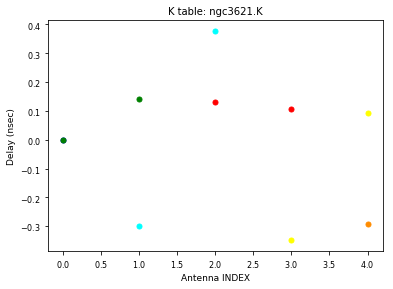

Show log 2019-08-22 14:13:43	INFO	plotcal::::	
 2019-08-22 14:13:43	INFO	plotcal::::+	##########################################
 2019-08-22 14:13:43	INFO	plotcal::::+	##### Begin Task: plotcal #####
 2019-08-22 14:13:43	INFO	plotcal::::	plotcal(caltable="ngc3621.K",xaxis="antenna",yaxis="delay",poln="",field="",
 2019-08-22 14:13:43	INFO	plotcal::::+ antenna="",spw="",timerange="",subplot=111,overplot=False,
 2019-08-22 14:13:43	INFO	plotcal::::+ clearpanel="Auto",iteration="",plotrange=[],showflags=False,plotsymbol="o",
 2019-08-22 14:13:43	INFO	plotcal::::+ plotcolor="blue",markersize=5.0,fontsize=10.0,showgui=False,figfile="")
 2019-08-22 14:13:43	INFO	tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2019-08-22 14:13:43	INFO	plotcal::createCalTab Detected a NewCalTable!
 2019-08-22 14:13:43	INFO Now get the data
 2019-08-22 14:13:43	INFO Done Processing data ... 
 2019-08-22 14:13:43	INFO	plotcal::::	##### End Task: plotcal #####
 2019-08-22 14:13:43	INFO	plotcal::::+	##########################################

In [17]:
plotcal(caltable=ktable,
        xaxis='antenna', yaxis='delay',
        showgui=False)

####   Solve for the bandpass response
bandpass response = the variation of the complex antenna gains across the different channels.   
Run bandpass to solve for the complex gain as a function of channel across the passband.

In [18]:
btable = prefix + '.B'
rmtables(btable)

Show log 2019-08-22 14:13:47	INFO	rmtables::::	
 2019-08-22 14:13:47	INFO	rmtables::::+	##########################################
 2019-08-22 14:13:47	INFO	rmtables::::+	##### Begin Task: rmtables #####
 2019-08-22 14:13:47	INFO	rmtables::::	rmtables(tablenames="ngc3621.B")
 2019-08-22 14:13:47	WARN	rmtables::utils::removetable	Empty filename
 2019-08-22 14:13:47	WARN	rmtables::utils::removetable	Cannot delete file because it's not a table.
 2019-08-22 14:13:47	INFO	rmtables::::	##### End Task: rmtables #####
 2019-08-22 14:13:47	INFO	rmtables::::+	##########################################

A regular 'B' type solution can work well if you have lots of S/N on your bandpass calibrator. The parameter `combine='scan'` is needed to average together all scans on the calibrators.

In [19]:
bandpass(vis=msfile,
         caltable=btable,
         field=fluxcal,
         refant=ref_ant,
         solnorm=True,
         combine='scan',
         minblperant=4,
         solint='inf',
         bandtype='B',
         minsnr=3.0,
         gaintable=[gtable0, ktable])

Show log 2019-08-22 14:13:50	INFO	bandpass::::	
 2019-08-22 14:13:50	INFO	bandpass::::+	##########################################
 2019-08-22 14:13:50	INFO	bandpass::::+	##### Begin Task: bandpass #####
 2019-08-22 14:13:50	INFO	bandpass::::	bandpass(vis="ngc3621_fixvis.ms",caltable="ngc3621.B",field="0408-65",spw="",intent="",
 2019-08-22 14:13:50	INFO	bandpass::::+ selectdata=True,timerange="",uvrange="",antenna="",scan="",
 2019-08-22 14:13:50	INFO	bandpass::::+ observation="",msselect="",solint="inf",combine="scan",refant="m003",
 2019-08-22 14:13:50	INFO	bandpass::::+ minblperant=4,minsnr=3.0,solnorm=True,bandtype="B",smodel=[],
 2019-08-22 14:13:50	INFO	bandpass::::+ append=False,fillgaps=0,degamp=3,degphase=3,visnorm=False,
 2019-08-22 14:13:50	INFO	bandpass::::+ maskcenter=0,maskedge=5,docallib=False,callib="",gaintable=['ngc3621.G0', 'ngc3621.K'],
 2019-08-22 14:13:50	INFO	bandpass::::+ gainfield=[''],interp=[],spwmap=[],parang=False)
 2019-08-22 14:13:50	INFO	bandpass::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-08-22 14:13:50	INFO	bandpass::calibrater::open	Opening MS: ngc3621_fixvis.ms for calibration.
 2019-08-22 14:13:50	INFO	bandpass::Calibrater::	Initializing nominal selection to the whole MS.
 2019-08-22 14:13:50	INFO	bandpass::calibrater::reset	Reseting solve/apply state
 2019-08-22 14:13:50	INFO	bandpass::::	NB: bandpass automatically excludes auto-correlations.
 2019-08-22 14:13:50	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-08-22 14:13:50	INFO	calibrater::reset	Reseting solve/apply state
 2019-08-22 14:13:50	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2019-08-22 14:13:50	INFO	Calibrater::selectvis+ Selecting on field: '0408-65'
 2019-08-22 14:13:50	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2019-08-22 14:13:50	INFO	Calibrater::selectvis	By selection 15687 rows are reduced to 2235
 2019-08-22 14:13:50	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2019-08-22 14:13:50	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2019-08-22 14:13:50	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:13:50	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:13:50	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=ngc3621.G0 select= interp=linear spwmap=[-1] calWt=true
 2019-08-22 14:13:50	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:13:50	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:13:50	INFO (K Jones: Enforcing calWt()=false for phase/delay-like terms)
 2019-08-22 14:13:50	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:13:50	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2019-08-22 14:13:50	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2019-08-22 14:13:50	INFO	Calibrater::setsolve	. B Jones: table=ngc3621.B append=false solint=inf,none refantmode='flex' refant='m003' minsnr=3 apmode=AP solnorm=true normtype=MEAN
 2019-08-22 14:13:50	INFO	calibrater::solve	Beginning solve-----------------------------
 2019-08-22 14:13:50	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2019-08-22 14:13:50	INFO	Calibrater::solve	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:13:50	INFO	Calibrater::solve	. G Jones: table=ngc3621.G0 select= interp=linear spwmap=[-1] calWt=true
 2019-08-22 14:13:50	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2019-08-22 14:13:50	INFO	Calibrater::solve	. B Jones: table=ngc3621.B append=false solint=inf,none refantmode='flex' refant='m003' minsnr=3 apmode=AP solnorm=true normtype=MEAN
 2019-08-22 14:13:50	INFO	Calibrater::solve	For

Since we asked bandpass to normalise the solution, the amplitude should be fairly stable around 1.

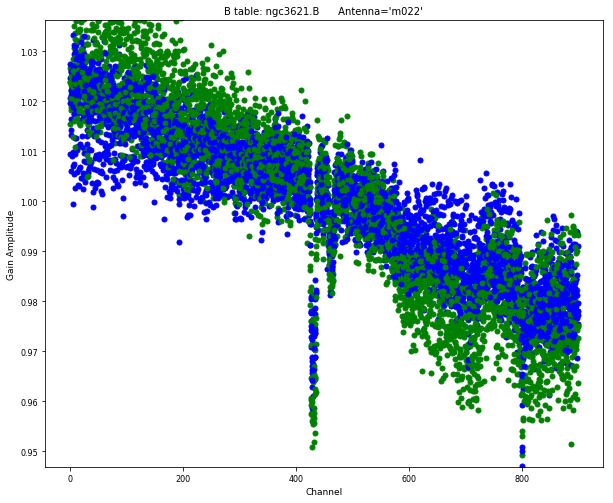

Show log 2019-08-22 14:13:55	INFO	plotcal::::	
 2019-08-22 14:13:55	INFO	plotcal::::+	##########################################
 2019-08-22 14:13:55	INFO	plotcal::::+	##### Begin Task: plotcal #####
 2019-08-22 14:13:55	INFO	plotcal::::	plotcal(caltable="ngc3621.B",xaxis="chan",yaxis="amp",poln="",field="0408-65",
 2019-08-22 14:13:55	INFO	plotcal::::+ antenna="",spw="",timerange="",subplot=321,overplot=False,
 2019-08-22 14:13:55	INFO	plotcal::::+ clearpanel="Auto",iteration="antenna",plotrange=[],showflags=False,plotsymbol="o",
 2019-08-22 14:13:55	INFO	plotcal::::+ plotcolor="blue",markersize=5.0,fontsize=10.0,showgui=False,figfile="")
 2019-08-22 14:13:55	INFO	tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2019-08-22 14:13:55	INFO	plotcal::createCalTab Detected a NewCalTable!
 2019-08-22 14:13:55	INFO Now get the data
 2019-08-22 14:13:55	INFO Done Processing data ... 
 2019-08-22 14:13:59	INFO Now get the data
 2019-08-22 14:13:59	INFO Done Processing data ... 
 2019-08-22 14:14:05	INFO Now get the data
 2019-08-22 14:14:05	INFO Done Processing data ... 
 2019-08-22 14:14:15	INFO Now get the data
 2019-08-22 14:14:15	INFO Done Processing data ... 
 2019-08-22 14:14:29	INFO Now get the data
 2019-08-22 14:14:29	INFO Done Processing data ... 
 2019-08-22 14:14:48	INFO Now get the data
 2019-08-22 14:14:48	INFO Done Processing data ... 
 2019-08-22 14:14:48	INFO	plotcal::::	##### End Task: plotcal #####
 2019-08-22 14:14:48	INFO	plotcal::::+	##########################################

In [20]:
plt.figure(figsize=[10,8])
plotcal(caltable=btable,
        xaxis='chan', yaxis='amp',
        field=fluxcal,
        subplot=321, iteration='antenna',
        showgui=False,
        )

Use `plotcal` to display the bandpass solution   
Phases should be fairly stable around 0 deg.

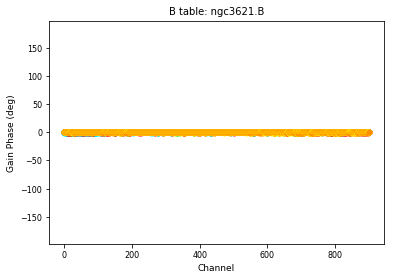

Show log 2019-08-22 14:14:59	INFO	plotcal::::	
 2019-08-22 14:14:59	INFO	plotcal::::+	##########################################
 2019-08-22 14:14:59	INFO	plotcal::::+	##### Begin Task: plotcal #####
 2019-08-22 14:14:59	INFO	plotcal::::	plotcal(caltable="ngc3621.B",xaxis="chan",yaxis="phase",poln="",field="0408-65",
 2019-08-22 14:14:59	INFO	plotcal::::+ antenna="",spw="",timerange="",subplot=111,overplot=False,
 2019-08-22 14:14:59	INFO	plotcal::::+ clearpanel="Auto",iteration="",plotrange=[-1, -1, -180, 180],showflags=False,plotsymbol="o",
 2019-08-22 14:14:59	INFO	plotcal::::+ plotcolor="blue",markersize=5.0,fontsize=10.0,showgui=False,figfile="")
 2019-08-22 14:14:59	INFO	tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2019-08-22 14:14:59	INFO	plotcal::createCalTab Detected a NewCalTable!
 2019-08-22 14:14:59	INFO Now get the data
 2019-08-22 14:14:59	INFO Done Processing data ... 
 2019-08-22 14:16:01	INFO	plotcal::::	##### End Task: plotcal #####
 2019-08-22 14:16:01	INFO	plotcal::::+	##########################################

In [21]:
plotcal(caltable=btable,
        xaxis='chan', yaxis='phase',
        field=fluxcal,
        plotrange = [-1, -1, -180, 180], showgui=False,
        )

In [22]:
applycal(vis=msfile,
         gaintable=[btable, ktable],
         calwt=False,
         applymode='calflag')

Show log 2019-08-22 14:16:14	INFO	applycal::::	
 2019-08-22 14:16:14	INFO	applycal::::+	##########################################
 2019-08-22 14:16:14	INFO	applycal::::+	##### Begin Task: applycal #####
 2019-08-22 14:16:14	INFO	applycal::::	applycal(vis="ngc3621_fixvis.ms",field="",spw="",intent="",selectdata=True,
 2019-08-22 14:16:14	INFO	applycal::::+ timerange="",uvrange="",antenna="",scan="",observation="",
 2019-08-22 14:16:14	INFO	applycal::::+ msselect="",docallib=False,callib="",gaintable=['ngc3621.B', 'ngc3621.K'],gainfield=[],
 2019-08-22 14:16:14	INFO	applycal::::+ interp=[],spwmap=[],calwt=False,parang=False,applymode="calflag",
 2019-08-22 14:16:14	INFO	applycal::::+ flagbackup=True)
 2019-08-22 14:16:14	INFO	applycal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-08-22 14:16:14	INFO	applycal::calibrater::open	Opening MS: ngc3621_fixvis.ms for calibration.
 2019-08-22 14:16:14	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2019-08-22 14:16:14	INFO	applycal::AgentFlagger::open	Table type is Measurement Set
 2019-08-22 14:16:14	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called applycal_1
 2019-08-22 14:16:15	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-08-22 14:16:15	INFO	calibrater::reset	Reseting solve/apply state
 2019-08-22 14:16:15	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2019-08-22 14:16:15	INFO	Calibrater::selectvis	Selection did not drop any rows
 2019-08-22 14:16:15	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2019-08-22 14:16:15	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2019-08-22 14:16:15	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:16:15	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:16:15	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=ngc3621.B select= interp=linear,linear spwmap=[-1] calWt=false
 2019-08-22 14:16:15	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:16:15	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:16:15	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:16:15	INFO	calibrater::correct	Beginning correct---------------------------
 2019-08-22 14:16:15	INFO	Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2019-08-22 14:16:15	INFO	Calibrater::correct2 (VI2/VB2)	. B Jones: table=ngc3621.B select= interp=linear,linear spwmap=[-1] calWt=false
 2019-08-22 14:16:15	INFO	Calibrater::correct2 (VI2/VB2)	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:16:17	INFO	calibrater::correct	Finished correcting.
 2019-08-22 14:16:17	INFO	applycal::::	Calibration apply flagging statistics (among calibrateable spws):
 2019-08-22 14:16:17	INFO	applycal:::: Total visibilities selected for correction (ncorr x nchan x nrow summed over spws) = 28236600
 2019-08-22 14:16:17	INFO	applycal:::: Flags:
 2019-08-22 14:16:17	INFO	applycal:::: B Jones: In: 14790600 / 28236600 (52.380952381%) --> Out: 14790600 / 28236600 (52.380952381%) (ngc3621.B)
 2019-08-22 14:16:17	INFO	applycal:::: K Jones: In: 14790600 / 28236600 (52.380952381%) --> Out: 14790600 / 28236600 (52.380952381%) (ngc3621.K)
 2019-08-22 14:16:17	INFO	applycal::::	CASA Version 5.5.0-149 
 2019-08-22 14:16:17	INFO	applycal::::	
 2019-08-22 14:16:17	INFO	applycal::::	##### End Task: applycal #####
 2019-08-22 14:16:17	INFO	applycal::::+	##########################################

#### Solve for the complex gain solution
Solving for the main time variable part of each source.
* Amplitude calibration was done on the primary amplitude flux calibrator.
* Use this to solve for the complex gain solutions of the secondary gain/phase calibrator source.

Gain calibration on fluxscale calibrator

Apply the bandpass solution while re-calculating with `gaincal` for calibrators on a short time interval (here, we use the integration time, this may be increased to a couple of seconds depending on observation).

In [23]:
gtable = prefix + '.G'
rmtables(gtable)

Show log 2019-08-22 14:16:36	INFO	rmtables::::	
 2019-08-22 14:16:36	INFO	rmtables::::+	##########################################
 2019-08-22 14:16:36	INFO	rmtables::::+	##### Begin Task: rmtables #####
 2019-08-22 14:16:36	INFO	rmtables::::	rmtables(tablenames="ngc3621.G")
 2019-08-22 14:16:36	WARN	rmtables::utils::removetable	Empty filename
 2019-08-22 14:16:36	WARN	rmtables::utils::removetable	Cannot delete file because it's not a table.
 2019-08-22 14:16:36	INFO	rmtables::::	##### End Task: rmtables #####
 2019-08-22 14:16:36	INFO	rmtables::::+	##########################################

In [24]:
gaincal(vis=msfile,
        caltable=gtable,
        field=fluxcal,
        solint='int',
        refant=ref_ant,
        combine='scan',
        gaintype='G',
        calmode='ap',
        minsnr=1.0,
        solnorm=False,
        gaintable=[btable, ktable])

Show log 2019-08-22 14:16:38	INFO	gaincal::::	
 2019-08-22 14:16:38	INFO	gaincal::::+	##########################################
 2019-08-22 14:16:38	INFO	gaincal::::+	##### Begin Task: gaincal #####
 2019-08-22 14:16:38	INFO	gaincal::::	gaincal(vis="ngc3621_fixvis.ms",caltable="ngc3621.G",field="0408-65",spw="",intent="",
 2019-08-22 14:16:38	INFO	gaincal::::+ selectdata=True,timerange="",uvrange="",antenna="",scan="",
 2019-08-22 14:16:38	INFO	gaincal::::+ observation="",msselect="",solint="int",combine="scan",preavg=-1.0,
 2019-08-22 14:16:38	INFO	gaincal::::+ refant="m003",refantmode="flex",minblperant=4,minsnr=1.0,solnorm=False,
 2019-08-22 14:16:38	INFO	gaincal::::+ normtype="mean",gaintype="G",smodel=[],calmode="ap",solmode="",
 2019-08-22 14:16:38	INFO	gaincal::::+ rmsthresh=[],append=False,splinetime=3600.0,npointaver=3,phasewrap=180.0,
 2019-08-22 14:16:38	INFO	gaincal::::+ docallib=False,callib="",gaintable=['ngc3621.B', 'ngc3621.K'],gainfield=[''],interp=[],
 2019-08-22 14:16:38	INFO	gaincal::::+ spwmap=[],parang=False)
 2019-08-22 14:16:38	INFO	gaincal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-08-22 14:16:38	INFO	gaincal::calibrater::open	Opening MS: ngc3621_fixvis.ms for calibration.
 2019-08-22 14:16:38	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2019-08-22 14:16:38	INFO	gaincal::::	NB: gaincal automatically excludes auto-correlations.
 2019-08-22 14:16:38	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-08-22 14:16:38	INFO	calibrater::reset	Reseting solve/apply state
 2019-08-22 14:16:38	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2019-08-22 14:16:38	INFO	Calibrater::selectvis+ Selecting on field: '0408-65'
 2019-08-22 14:16:38	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2019-08-22 14:16:38	INFO	Calibrater::selectvis	By selection 15687 rows are reduced to 2235
 2019-08-22 14:16:38	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2019-08-22 14:16:38	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2019-08-22 14:16:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:16:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:16:38	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=ngc3621.B select= interp=linear,linear spwmap=[-1] calWt=true
 2019-08-22 14:16:38	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:16:38	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:16:38	INFO (K Jones: Enforcing calWt()=false for phase/delay-like terms)
 2019-08-22 14:16:38	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:16:38	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2019-08-22 14:16:38	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2019-08-22 14:16:38	INFO	Calibrater::setsolve	. G Jones: table=ngc3621.G append=false solint=int refantmode='flex' refant='m003' minsnr=1 apmode=AP solnorm=false
 2019-08-22 14:16:38	INFO	calibrater::solve	Beginning solve-----------------------------
 2019-08-22 14:16:38	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2019-08-22 14:16:38	INFO	Calibrater::solve	. B Jones: table=ngc3621.B select= interp=linear,linear spwmap=[-1] calWt=true
 2019-08-22 14:16:38	INFO	Calibrater::solve	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:16:38	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2019-08-22 14:16:38	INFO	Calibrater::solve	. G Jones: table=ngc3621.G append=false solint=int refantmode='flex' refant='m003' minsnr=1 apmode=AP solnorm=false
 2019-08-22 14:16:38	INFO	ChannelAverageTVI::parseConfiguration	Chan

This will be followed by appending complex gains solutions for the secondary phase calibrator

To avoid decorrelation of the amplitude, the phase solutions fed to the amplitude calibration step should be at the shortest solint your S/N can support. Typically this will be the integration time.

In [25]:
gaincal(vis=msfile,
        caltable=gtable,
        field=phasecal,
        solint='int',
        refant=ref_ant,
        combine='scan',
        gaintype='G',
        calmode='ap',
        minsnr=1.0,
        solnorm=False,
        append=True,
        gaintable=[btable, ktable])

Show log 2019-08-22 14:16:42	INFO	gaincal::::	
 2019-08-22 14:16:42	INFO	gaincal::::+	##########################################
 2019-08-22 14:16:42	INFO	gaincal::::+	##### Begin Task: gaincal #####
 2019-08-22 14:16:42	INFO	gaincal::::	gaincal(vis="ngc3621_fixvis.ms",caltable="ngc3621.G",field="1117-248",spw="",intent="",
 2019-08-22 14:16:42	INFO	gaincal::::+ selectdata=True,timerange="",uvrange="",antenna="",scan="",
 2019-08-22 14:16:42	INFO	gaincal::::+ observation="",msselect="",solint="int",combine="scan",preavg=-1.0,
 2019-08-22 14:16:42	INFO	gaincal::::+ refant="m003",refantmode="flex",minblperant=4,minsnr=1.0,solnorm=False,
 2019-08-22 14:16:42	INFO	gaincal::::+ normtype="mean",gaintype="G",smodel=[],calmode="ap",solmode="",
 2019-08-22 14:16:42	INFO	gaincal::::+ rmsthresh=[],append=True,splinetime=3600.0,npointaver=3,phasewrap=180.0,
 2019-08-22 14:16:42	INFO	gaincal::::+ docallib=False,callib="",gaintable=['ngc3621.B', 'ngc3621.K'],gainfield=[''],interp=[],
 2019-08-22 14:16:42	INFO	gaincal::::+ spwmap=[],parang=False)
 2019-08-22 14:16:42	INFO	gaincal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-08-22 14:16:42	INFO	gaincal::calibrater::open	Opening MS: ngc3621_fixvis.ms for calibration.
 2019-08-22 14:16:42	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2019-08-22 14:16:42	INFO	gaincal::::	NB: gaincal automatically excludes auto-correlations.
 2019-08-22 14:16:42	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-08-22 14:16:42	INFO	calibrater::reset	Reseting solve/apply state
 2019-08-22 14:16:42	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2019-08-22 14:16:42	INFO	Calibrater::selectvis+ Selecting on field: '1117-248'
 2019-08-22 14:16:42	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2019-08-22 14:16:42	INFO	Calibrater::selectvis	By selection 15687 rows are reduced to 2220
 2019-08-22 14:16:42	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2019-08-22 14:16:42	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2019-08-22 14:16:42	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:16:42	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:16:42	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=ngc3621.B select= interp=linear,linear spwmap=[-1] calWt=true
 2019-08-22 14:16:42	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:16:42	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:16:42	INFO (K Jones: Enforcing calWt()=false for phase/delay-like terms)
 2019-08-22 14:16:42	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:16:42	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2019-08-22 14:16:42	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2019-08-22 14:16:42	INFO	Calibrater::setsolve	. G Jones: table=ngc3621.G append=true solint=int refantmode='flex' refant='m003' minsnr=1 apmode=AP solnorm=false
 2019-08-22 14:16:42	INFO	calibrater::solve	Beginning solve-----------------------------
 2019-08-22 14:16:42	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2019-08-22 14:16:42	INFO	Calibrater::solve	. B Jones: table=ngc3621.B select= interp=linear,linear spwmap=[-1] calWt=true
 2019-08-22 14:16:42	INFO	Calibrater::solve	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:16:42	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2019-08-22 14:16:42	INFO	Calibrater::solve	. G Jones: table=ngc3621.G append=true solint=int refantmode='flex' refant='m003' minsnr=1 apmode=AP solnorm=false
 2019-08-22 14:16:42	INFO	ChannelAverageTVI::parseConfiguration	Chann

Use the plotting tool to look at the solution:
Since we are working with the corrected flux density for this source, these gains have already been corrected and should lie around 0.1

And the phases all lining up

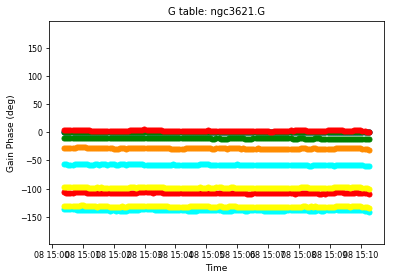

Show log 2019-08-22 14:16:45	INFO	plotcal::::	
 2019-08-22 14:16:45	INFO	plotcal::::+	##########################################
 2019-08-22 14:16:45	INFO	plotcal::::+	##### Begin Task: plotcal #####
 2019-08-22 14:16:45	INFO	plotcal::::	plotcal(caltable="ngc3621.G",xaxis="time",yaxis="phase",poln="",field="0408-65",
 2019-08-22 14:16:45	INFO	plotcal::::+ antenna="",spw="",timerange="",subplot=111,overplot=False,
 2019-08-22 14:16:45	INFO	plotcal::::+ clearpanel="Auto",iteration="",plotrange=[-1, -1, -180, 180],showflags=False,plotsymbol="o",
 2019-08-22 14:16:45	INFO	plotcal::::+ plotcolor="blue",markersize=5.0,fontsize=10.0,showgui=False,figfile="")
 2019-08-22 14:16:45	INFO	tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2019-08-22 14:16:45	INFO	plotcal::createCalTab Detected a NewCalTable!
 2019-08-22 14:16:45	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:16:45	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:16:45	INFO	plotcal::::	##### End Task: plotcal #####
 2019-08-22 14:16:45	INFO	plotcal::::+	##########################################

In [26]:
plotcal(caltable=gtable,
        xaxis='time', yaxis='phase',
        field=fluxcal,
        plotrange=[-1, -1, -180, 180], showgui=False)

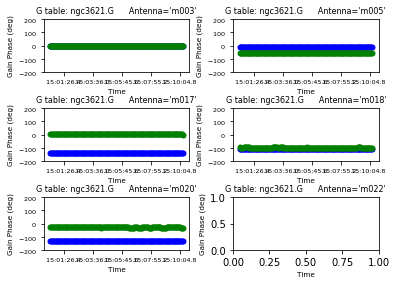

Show log 2019-08-22 14:17:08	INFO	plotcal::::	
 2019-08-22 14:17:08	INFO	plotcal::::+	##########################################
 2019-08-22 14:17:08	INFO	plotcal::::+	##### Begin Task: plotcal #####
 2019-08-22 14:17:08	INFO	plotcal::::	plotcal(caltable="ngc3621.G",xaxis="time",yaxis="phase",poln="",field="0408-65",
 2019-08-22 14:17:08	INFO	plotcal::::+ antenna="",spw="",timerange="",subplot=321,overplot=False,
 2019-08-22 14:17:08	INFO	plotcal::::+ clearpanel="Auto",iteration="antenna",plotrange=[-1, -1, -180, 180],showflags=False,plotsymbol="o",
 2019-08-22 14:17:08	INFO	plotcal::::+ plotcolor="blue",markersize=5.0,fontsize=8,showgui=True,figfile="")
 2019-08-22 14:17:08	INFO	tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2019-08-22 14:17:08	INFO	plotcal::createCalTab Detected a NewCalTable!
 2019-08-22 14:17:08	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:08	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:08	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:08	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:08	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:08	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:08	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:08	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:08	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:08	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:09	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:09	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:09	INFO	plotcal::::	##### End Task: plotcal #####
 2019-08-22 14:17:09	INFO	plotcal::::+	##########################################

In [30]:
plt.figure(figsize=[10,8])
plotcal(caltable=gtable,
        xaxis='time', yaxis='phase',
        field=fluxcal,
        subplot=321, iteration='antenna',
        plotrange=[-1, -1, -180, 180],
        fontsize=8, showgui=True)

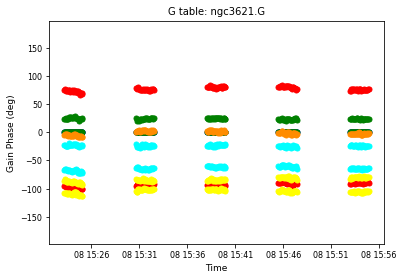

Show log 2019-08-22 14:16:51	INFO	plotcal::::	
 2019-08-22 14:16:51	INFO	plotcal::::+	##########################################
 2019-08-22 14:16:51	INFO	plotcal::::+	##### Begin Task: plotcal #####
 2019-08-22 14:16:51	INFO	plotcal::::	plotcal(caltable="ngc3621.G",xaxis="time",yaxis="phase",poln="",field="1117-248",
 2019-08-22 14:16:51	INFO	plotcal::::+ antenna="",spw="",timerange="",subplot=111,overplot=False,
 2019-08-22 14:16:51	INFO	plotcal::::+ clearpanel="Auto",iteration="",plotrange=[-1, -1, -180, 180],showflags=False,plotsymbol="o",
 2019-08-22 14:16:51	INFO	plotcal::::+ plotcolor="blue",markersize=5.0,fontsize=10.0,showgui=False,figfile="")
 2019-08-22 14:16:51	INFO	tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2019-08-22 14:16:51	INFO	plotcal::createCalTab Detected a NewCalTable!
 2019-08-22 14:16:51	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:16:51	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:16:51	INFO	plotcal::::	##### End Task: plotcal #####
 2019-08-22 14:16:51	INFO	plotcal::::+	##########################################

In [28]:
plotcal(caltable=gtable,
        xaxis='time', yaxis='phase',
        field=phasecal,
        plotrange=[-1, -1, -180, 180], showgui=False)

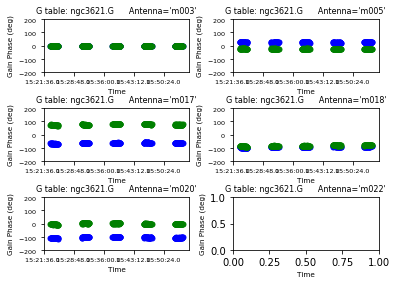

Show log 2019-08-22 14:17:20	INFO	plotcal::::	
 2019-08-22 14:17:20	INFO	plotcal::::+	##########################################
 2019-08-22 14:17:20	INFO	plotcal::::+	##### Begin Task: plotcal #####
 2019-08-22 14:17:20	INFO	plotcal::::	plotcal(caltable="ngc3621.G",xaxis="time",yaxis="phase",poln="",field="1117-248",
 2019-08-22 14:17:20	INFO	plotcal::::+ antenna="",spw="",timerange="",subplot=321,overplot=False,
 2019-08-22 14:17:20	INFO	plotcal::::+ clearpanel="Auto",iteration="antenna",plotrange=[-1, -1, -180, 180],showflags=False,plotsymbol="o",
 2019-08-22 14:17:20	INFO	plotcal::::+ plotcolor="blue",markersize=5.0,fontsize=8,showgui=False,figfile="")
 2019-08-22 14:17:20	INFO	tableplot::setgui	Switching to NO-GUI mode. All current plots will be reset.
 2019-08-22 14:17:20	INFO	plotcal::createCalTab Detected a NewCalTable!
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:20	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:20	INFO	plotcal::::	##### End Task: plotcal #####
 2019-08-22 14:17:20	INFO	plotcal::::+	##########################################

In [32]:
plt.figure(figsize=[10,8])
plotcal(caltable=gtable,
        xaxis='time', yaxis='phase',
        field=phasecal,
        subplot=321, iteration='antenna',
        plotrange=[-1, -1, -180, 180],
        fontsize=8, showgui=False)

For calibrator sources we expect values that are consistent across baselines and vary only slightly across channels. Thus plot amplitude for all baseline together.

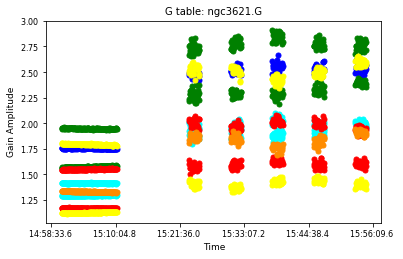

Show log 2019-08-22 14:17:31	INFO	plotcal::::	
 2019-08-22 14:17:31	INFO	plotcal::::+	##########################################
 2019-08-22 14:17:31	INFO	plotcal::::+	##### Begin Task: plotcal #####
 2019-08-22 14:17:31	INFO	plotcal::::	plotcal(caltable="ngc3621.G",xaxis="time",yaxis="amp",poln="",field="",
 2019-08-22 14:17:31	INFO	plotcal::::+ antenna="",spw="",timerange="",subplot=111,overplot=False,
 2019-08-22 14:17:31	INFO	plotcal::::+ clearpanel="Auto",iteration="",plotrange=[],showflags=False,plotsymbol="o",
 2019-08-22 14:17:31	INFO	plotcal::::+ plotcolor="blue",markersize=5.0,fontsize=10.0,showgui=True,figfile="")
 2019-08-22 14:17:31	INFO	tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2019-08-22 14:17:31	INFO	plotcal::createCalTab Detected a NewCalTable!
 2019-08-22 14:17:31	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-08-22 14:17:31	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-08-22 14:17:31	INFO	plotcal::::	##### End Task: plotcal #####
 2019-08-22 14:17:31	INFO	plotcal::::+	##########################################

In [33]:
plotcal(caltable = gtable, xaxis = 'time', yaxis = 'amp')

If the fluxes for secondary calibrators have not been corrected yet there are offset from the true flux.

Derive the scale factor difference between the primary and secondary calibrator sources. Apply scale factor to secondary calibrator to obtain true flux density for this source.
The task fluxscale performs the bootstrapping and calculates the scale factor.

Either use a model that is provided, or use a CASA image model that can be obtained from self-calibration
```
setjy(vis=msfile, listmodels=True)
```
```
fluxscale(vis=msfile, caltable=gtable, fluxtable=ftable, reference=[fluxcal], transfer=[phasecal])
```

In [34]:
ftable = prefix + '.flux'
rmtables(ftable)

Show log 2019-08-22 14:17:35	INFO	rmtables::::	
 2019-08-22 14:17:35	INFO	rmtables::::+	##########################################
 2019-08-22 14:17:35	INFO	rmtables::::+	##### Begin Task: rmtables #####
 2019-08-22 14:17:35	INFO	rmtables::::	rmtables(tablenames="ngc3621.flux")
 2019-08-22 14:17:35	WARN	rmtables::utils::removetable	Empty filename
 2019-08-22 14:17:35	WARN	rmtables::utils::removetable	Cannot delete file because it's not a table.
 2019-08-22 14:17:35	INFO	rmtables::::	##### End Task: rmtables #####
 2019-08-22 14:17:35	INFO	rmtables::::+	##########################################

In [35]:
fluxscale(vis=msfile,
          caltable=gtable,
          fluxtable=ftable,
          reference=[fluxcal],
          transfer=[phasecal],
          )

{'2': {'0': {'fluxd': array([ 1.9662912,  0.       ,  0.       ,  0.       ]),
   'fluxdErr': array([ 0.04917324,  0.        ,  0.        ,  0.        ]),
   'numSol': array([ 10.,   0.,   0.,   0.])},
  'covarMat': array([], shape=(0, 0), dtype=float64),
  'fieldName': '1117-248',
  'fitFluxd': 0.0,
  'fitFluxdErr': 0.0,
  'fitRefFreq': 0.0,
  'spidx': array([ 0.,  0.]),
  'spidxerr': array([ 0.,  0.])},
 'freq': array([  1.41110168e+09]),
 'spwID': array([0], dtype=int32),
 'spwName': array(['none'],
       dtype='|S5')}

Show log 2019-08-22 14:17:37	INFO	fluxscale::::	
 2019-08-22 14:17:37	INFO	fluxscale::::+	##########################################
 2019-08-22 14:17:37	INFO	fluxscale::::+	##### Begin Task: fluxscale #####
 2019-08-22 14:17:37	INFO	fluxscale::::	fluxscale(vis="ngc3621_fixvis.ms",caltable="ngc3621.G",fluxtable="ngc3621.flux",reference=['0408-65'],transfer=['1117-248'],
 2019-08-22 14:17:37	INFO	fluxscale::::+ listfile="",append=False,refspwmap=[-1],gainthreshold=-1.0,antenna="",
 2019-08-22 14:17:37	INFO	fluxscale::::+ timerange="",scan="",incremental=False,fitorder=1,display=False)
 2019-08-22 14:17:37	INFO	fluxscale::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-08-22 14:17:37	INFO	fluxscale::calibrater::open	Opening MS: ngc3621_fixvis.ms for calibration.
 2019-08-22 14:17:37	INFO	fluxscale::Calibrater::	Initializing nominal selection to the whole MS.
 2019-08-22 14:17:37	INFO	fluxscale::calibrater::fluxscale	Beginning fluxscale--(MSSelection version)-------
 2019-08-22 14:17:37	INFO	fluxscale:::: Found reference field(s): 0408-65
 2019-08-22 14:17:37	INFO	fluxscale:::: Found transfer field(s): 1117-248
 2019-08-22 14:17:37	INFO	fluxscale:::: Flux density for 1117-248 in SpW=0 (freq=1.4111e+09 Hz) is: 1.96629 +/- 0.0491732 (SNR = 39.987, N = 10)
 2019-08-22 14:17:37	INFO	fluxscale::Calibrater::fluxscale	Storing result in ngc3621.flux
 2019-08-22 14:17:37	INFO	fluxscale::::	Writing solutions to table: ngc3621.flux
 2019-08-22 14:17:38	INFO	fluxscale::::	CASA Version 5.5.0-149 
 2019-08-22 14:17:38	INFO	fluxscale::::	
 2019-08-22 14:17:38	INFO	fluxscale::::	##### End Task: fluxscale #####
 2019-08-22 14:17:38	INFO	fluxscale::::+	##########################################

#### Apply calibration

Before imaging the data, the calibration results need to be applied and the calibrated data sets split to separate measurement sets.

Apply calibration separately to each source. You may include applying the calibration to the calibrators as well as the target sources to verify the calibration solutions.

In [36]:
print('---> Applycal: {}'.format(fluxcal))
applycal(vis=msfile,
         field=fluxcal,
         gaintable=[ftable, btable, ktable],
         parang=False,
         gainfield=[fluxcal, '', ''],
         interp=['', 'nearest', ''],
         calwt=False,
         applymode='calflag')

---> Applycal: 0408-65


Show log 2019-08-22 14:17:41	INFO	applycal::::	
 2019-08-22 14:17:41	INFO	applycal::::+	##########################################
 2019-08-22 14:17:41	INFO	applycal::::+	##### Begin Task: applycal #####
 2019-08-22 14:17:41	INFO	applycal::::	applycal(vis="ngc3621_fixvis.ms",field="0408-65",spw="",intent="",selectdata=True,
 2019-08-22 14:17:41	INFO	applycal::::+ timerange="",uvrange="",antenna="",scan="",observation="",
 2019-08-22 14:17:41	INFO	applycal::::+ msselect="",docallib=False,callib="",gaintable=['ngc3621.flux', 'ngc3621.B', 'ngc3621.K'],gainfield=['0408-65', '', ''],
 2019-08-22 14:17:41	INFO	applycal::::+ interp=['', 'nearest', ''],spwmap=[],calwt=False,parang=False,applymode="calflag",
 2019-08-22 14:17:41	INFO	applycal::::+ flagbackup=True)
 2019-08-22 14:17:41	INFO	applycal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-08-22 14:17:41	INFO	applycal::calibrater::open	Opening MS: ngc3621_fixvis.ms for calibration.
 2019-08-22 14:17:41	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2019-08-22 14:17:41	INFO	applycal::AgentFlagger::open	Table type is Measurement Set
 2019-08-22 14:17:41	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called applycal_2
 2019-08-22 14:17:41	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-08-22 14:17:41	INFO	calibrater::reset	Reseting solve/apply state
 2019-08-22 14:17:41	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2019-08-22 14:17:41	INFO	Calibrater::selectvis+ Selecting on field: '0408-65'
 2019-08-22 14:17:41	INFO	Calibrater::selectvis	By selection 15687 rows are reduced to 3129
 2019-08-22 14:17:41	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2019-08-22 14:17:41	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2019-08-22 14:17:41	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:17:41	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:17:41	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=ngc3621.flux select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:41	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:17:41	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:17:41	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=ngc3621.B select= interp=nearest,linear spwmap=[-1] calWt=false
 2019-08-22 14:17:41	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:17:41	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:17:41	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:41	INFO	calibrater::correct	Beginning correct---------------------------
 2019-08-22 14:17:41	INFO	Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2019-08-22 14:17:41	INFO	Calibrater::correct2 (VI2/VB2)	. B Jones: table=ngc3621.B select= interp=nearest,linear spwmap=[-1] calWt=false
 2019-08-22 14:17:41	INFO	Calibrater::correct2 (VI2/VB2)	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:41	INFO	Calibrater::correct2 (VI2/VB2)	. G Jones: table=ngc3621.flux select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:42	INFO	calibrater::correct	Finished correcting.
 2019-08-22 14:17:42	INFO	applycal::::	Calibration apply flagging statistics (among calibrateable spws):
 2019-08-22 14:17:42	INFO	applycal:::: Total visibilities selected for correction (ncorr x nchan x nrow summed over spws) = 5632200
 2019-08-22 14:17:42	INFO	applycal:::: Flags:
 2019-08-22 14:17:42	INFO	applycal:::: B Jones: In: 2950200 / 5632200 (52.380952381%) --> Out: 2950200 / 5632200 (52.380952381%) (ngc3621.B)
 2019-08-22 14:17:42	INFO	applycal:::: K Jone

In [37]:
print('---> Applycal: {}'.format(phasecal))
applycal(vis=msfile,
         field=phasecal,
         gaintable=[ftable, btable, ktable],
         parang=False,
         gainfield=[phasecal, '', ''],
         interp=['', 'nearest', ''],
         calwt=False,
         applymode='calflag')

---> Applycal: 1117-248


Show log 2019-08-22 14:17:43	INFO	applycal::::	
 2019-08-22 14:17:43	INFO	applycal::::+	##########################################
 2019-08-22 14:17:43	INFO	applycal::::+	##### Begin Task: applycal #####
 2019-08-22 14:17:43	INFO	applycal::::	applycal(vis="ngc3621_fixvis.ms",field="1117-248",spw="",intent="",selectdata=True,
 2019-08-22 14:17:43	INFO	applycal::::+ timerange="",uvrange="",antenna="",scan="",observation="",
 2019-08-22 14:17:43	INFO	applycal::::+ msselect="",docallib=False,callib="",gaintable=['ngc3621.flux', 'ngc3621.B', 'ngc3621.K'],gainfield=['1117-248', '', ''],
 2019-08-22 14:17:43	INFO	applycal::::+ interp=['', 'nearest', ''],spwmap=[],calwt=False,parang=False,applymode="calflag",
 2019-08-22 14:17:43	INFO	applycal::::+ flagbackup=True)
 2019-08-22 14:17:43	INFO	applycal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-08-22 14:17:43	INFO	applycal::calibrater::open	Opening MS: ngc3621_fixvis.ms for calibration.
 2019-08-22 14:17:43	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2019-08-22 14:17:43	INFO	applycal::AgentFlagger::open	Table type is Measurement Set
 2019-08-22 14:17:43	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called applycal_3
 2019-08-22 14:17:43	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-08-22 14:17:43	INFO	calibrater::reset	Reseting solve/apply state
 2019-08-22 14:17:43	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2019-08-22 14:17:43	INFO	Calibrater::selectvis+ Selecting on field: '1117-248'
 2019-08-22 14:17:43	INFO	Calibrater::selectvis	By selection 15687 rows are reduced to 3108
 2019-08-22 14:17:43	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2019-08-22 14:17:43	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2019-08-22 14:17:43	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:17:43	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:17:43	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=ngc3621.flux select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:43	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:17:43	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:17:43	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=ngc3621.B select= interp=nearest,linear spwmap=[-1] calWt=false
 2019-08-22 14:17:43	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:17:43	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:17:43	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:43	INFO	calibrater::correct	Beginning correct---------------------------
 2019-08-22 14:17:43	INFO	Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2019-08-22 14:17:43	INFO	Calibrater::correct2 (VI2/VB2)	. B Jones: table=ngc3621.B select= interp=nearest,linear spwmap=[-1] calWt=false
 2019-08-22 14:17:43	INFO	Calibrater::correct2 (VI2/VB2)	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:43	INFO	Calibrater::correct2 (VI2/VB2)	. G Jones: table=ngc3621.flux select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:43	INFO	calibrater::correct	Finished correcting.
 2019-08-22 14:17:43	INFO	applycal::::	Calibration apply flagging statistics (among calibrateable spws):
 2019-08-22 14:17:43	INFO	applycal:::: Total visibilities selected for correction (ncorr x nchan x nrow summed over spws) = 5594400
 2019-08-22 14:17:43	INFO	applycal:::: Flags:
 2019-08-22 14:17:43	INFO	applycal:::: B Jones: In: 2930400 / 5594400 (52.380952381%) --> Out: 2930400 / 5594400 (52.380952381%) (ngc3621.B)
 2019-08-22 14:17:43	INFO	applycal:::: K J

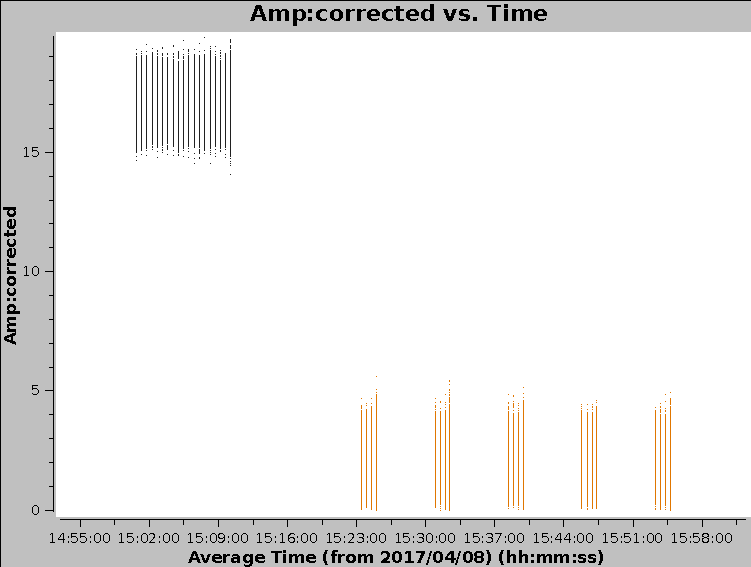

True

Show log 2019-08-22 14:19:07	INFO	plotms::::	
 2019-08-22 14:19:07	INFO	plotms::::+	##########################################
 2019-08-22 14:19:07	INFO	plotms::::+	##### Begin Task: plotms #####
 2019-08-22 14:19:07	INFO	plotms::::	plotms(vis="ngc3621_fixvis.ms",gridrows=1,gridcols=1,rowindex=0,colindex=0,
 2019-08-22 14:19:07	INFO	plotms::::+ plotindex=0,xaxis="time",xdatacolumn="",xframe="",xinterp="",
 2019-08-22 14:19:07	INFO	plotms::::+ yaxis="amp",ydatacolumn="corrected",yframe="",yinterp="",yaxislocation="",
 2019-08-22 14:19:07	INFO	plotms::::+ selectdata=True,field="0408-65,1117-248",spw="",timerange="",uvrange="",
 2019-08-22 14:19:07	INFO	plotms::::+ antenna="",scan="",correlation="",array="",observation="",
 2019-08-22 14:19:07	INFO	plotms::::+ intent="",feed="",msselect="",averagedata=True,avgchannel="",
 2019-08-22 14:19:07	INFO	plotms::::+ avgtime="30",avgscan=False,avgfield=False,avgbaseline=False,avgantenna=False,
 2019-08-22 14:19:07	INFO	plotms::::+ avgspw=False,scalar=False,transform=True,freqframe="",restfreq="",
 2019-08-22 14:19:07	INFO	plotms::::+ veldef="RADIO",shift=[0.0, 0.0],extendflag=False,extcorr=False,extchannel=False,
 2019-08-22 14:19:07	INFO	plotms::::+ iteraxis="",xselfscale=False,yselfscale=False,xsharedaxis=False,ysharedaxis=False,
 2019-08-22 14:19:07	INFO	plotms::::+ customsymbol=False,symbolshape="autoscaling",symbolsize=2,symbolcolor="0000ff",symbolfill="fill",
 2019-08-22 14:19:07	INFO	plotms::::+ symboloutline=False,coloraxis="field",customflaggedsymbol=False,flaggedsymbolshape="circle",flaggedsymbolsize=2,
 2019-08-22 14:19:07	INFO	plotms::::+ flaggedsymbolcolor="ff0000",flaggedsymbolfill="fill",flaggedsymboloutline=False,xconnector="",timeconnector=False,
 2019-08-22 14:19:07	INFO	plotms::::+ plotrange=[],title="",titlefont=0,xlabel="",xaxisfont=0,
 2019-08-22 14:19:07	INFO	plotms::::+ ylabel="",yaxisfont=0,showmajorgrid=False,majorwidth=1,majorstyle="",
 2019-08-22 14:19:07	INFO	plotms::::+ majorcolor="B0B0B0",showminorgrid=False,minorwidth=1,minorstyle="",minorcolor="D0D0D0",
 2019-08-22 14:19:07	INFO	plotms::::+ showlegend=False,legendposition="",plotfile="plotms_temp.png",expformat="",verbose=True,
 2019-08-22 14:19:07	INFO	plotms::::+ exprange="",highres=False,dpi=-1,width=-1,height=-1,
 2019-08-22 14:19:07	INFO	plotms::::+ overwrite=True,showgui=False,clearplots=True,callib=[''],headeritems="",
 2019-08-22 14:19:07	INFO	plotms::::+ showatm=False,showtsky=False)
 2019-08-22 14:19:09	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2019-08-22 14:19:09	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2019-08-22 14:19:09	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2019-08-22 14:19:09	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2019-08-22 14:19:09	INFO	PlotMS::load_cache	START Current memory usage: 2296.22 kilobytes.
 2019-08-22 14:19:09	INFO	PlotMS::load_cache	Plot Data Transformations:
 2019-08-22 14:19:09	INFO	PlotMS::load_cache+ Frame = 
 2019-08-22 14:19:09	INFO	PlotMS::load_cache+ VelDef = RADIO
 2019-08-22 14:19:09	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2019-08-22 14:19:09	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2019-08-22 14:19:09	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2019-08-22 14:19:09	INFO	PlotMS::load_cache+ formStokes = false
 2019-08-22 14:19:09	INFO	PlotMS::load_cache	Data Averaging: 
 2019-08-22 14:19:09	INFO	PlotMS::load_cache+ Using VECTOR averaging.
 2019-08-22 14:19:09	INFO	PlotMS::load_cache+ Time: 30 seconds. Scan: false; Field: false
 2019-08-22 14:19:09	INFO	PlotMS::load_cache	Plot Data Calibration:
 2019-08-22 14:19:09	INFO	PlotMS::load_cache+ Use Calibration = 0
 2019-08-22 14:19:09	INFO	PlotMS::load_cache+ Calibration Library = 
 2019-08-22 14:19:09	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17):corrected vs. Time(2)...
 2019-08-22 14:19:09	INFO	

In [41]:
plotms(vis=msfile,
       xaxis='time',
       yaxis='amp',
       ydatacolumn='corrected', 
       averagedata=True,
       avgtime='30',
       field='0408-65,1117-248',
       coloraxis='field')

#### Inspect calibration solutions
It is a good idea to briefly examine the calibrated visibility data for the calibrated target source in case there is more bad data we need to flag.

**Do not re-apply calibration to these targets after flagging -- this flagging is for clean and imaging, not for calibration.**

To check that everything has truly proceeded as well as we would like, this is a good time to look at the calibrated data in plotms.
* A very useful way to check the goodness of calibration is to plot the corrected amplitude vs. corrected phase (which should look like a tight ball for a point source, and will have organized structure if the source is resolved),
* and corrected amplitude vs. baseline, which should be a flat line of points for a point source, and will reveal any lingering antenna-based problems.
* For a resolved source, it may be more instructive to plot corrected amplitude vs. uv-distance.

Apply calibration solution to a flux calibrator source to visually verify calibration solution. For a point source we do not expect the flux density (amplitude) to vary across baselines, but remain approximately stable.

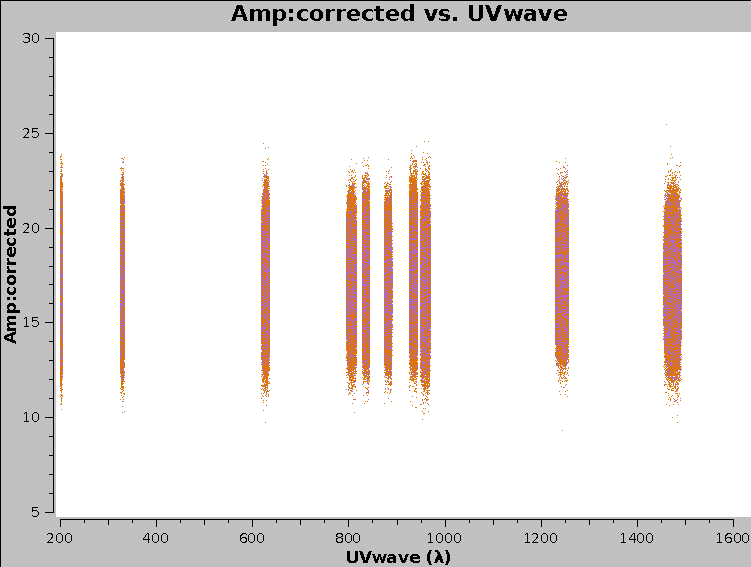

True

Show log 2019-08-22 14:20:01	INFO	plotms::::	
 2019-08-22 14:20:01	INFO	plotms::::+	##########################################
 2019-08-22 14:20:01	INFO	plotms::::+	##### Begin Task: plotms #####
 2019-08-22 14:20:01	INFO	plotms::::	plotms(vis="ngc3621_fixvis.ms",gridrows=1,gridcols=1,rowindex=0,colindex=0,
 2019-08-22 14:20:01	INFO	plotms::::+ plotindex=0,xaxis="uvwave",xdatacolumn="",xframe="",xinterp="",
 2019-08-22 14:20:01	INFO	plotms::::+ yaxis="amp",ydatacolumn="corrected",yframe="",yinterp="",yaxislocation="",
 2019-08-22 14:20:01	INFO	plotms::::+ selectdata=True,field="0408-65",spw="",timerange="",uvrange="",
 2019-08-22 14:20:01	INFO	plotms::::+ antenna="",scan="",correlation="XX,YY",array="",observation="",
 2019-08-22 14:20:01	INFO	plotms::::+ intent="",feed="",msselect="",averagedata=True,avgchannel="",
 2019-08-22 14:20:01	INFO	plotms::::+ avgtime="",avgscan=False,avgfield=False,avgbaseline=False,avgantenna=False,
 2019-08-22 14:20:01	INFO	plotms::::+ avgspw=False,scalar=False,transform=True,freqframe="",restfreq="",
 2019-08-22 14:20:01	INFO	plotms::::+ veldef="RADIO",shift=[0.0, 0.0],extendflag=False,extcorr=False,extchannel=False,
 2019-08-22 14:20:01	INFO	plotms::::+ iteraxis="",xselfscale=False,yselfscale=False,xsharedaxis=False,ysharedaxis=False,
 2019-08-22 14:20:01	INFO	plotms::::+ customsymbol=False,symbolshape="autoscaling",symbolsize=2,symbolcolor="0000ff",symbolfill="fill",
 2019-08-22 14:20:01	INFO	plotms::::+ symboloutline=False,coloraxis="corr",customflaggedsymbol=False,flaggedsymbolshape="circle",flaggedsymbolsize=2,
 2019-08-22 14:20:01	INFO	plotms::::+ flaggedsymbolcolor="ff0000",flaggedsymbolfill="fill",flaggedsymboloutline=False,xconnector="",timeconnector=False,
 2019-08-22 14:20:01	INFO	plotms::::+ plotrange=[],title="",titlefont=0,xlabel="",xaxisfont=0,
 2019-08-22 14:20:01	INFO	plotms::::+ ylabel="",yaxisfont=0,showmajorgrid=False,majorwidth=1,majorstyle="",
 2019-08-22 14:20:01	INFO	plotms::::+ majorcolor="B0B0B0",showminorgrid=False,minorwidth=1,minorstyle="",minorcolor="D0D0D0",
 2019-08-22 14:20:01	INFO	plotms::::+ showlegend=False,legendposition="",plotfile="plotms_temp.png",expformat="",verbose=True,
 2019-08-22 14:20:01	INFO	plotms::::+ exprange="",highres=False,dpi=-1,width=-1,height=-1,
 2019-08-22 14:20:01	INFO	plotms::::+ overwrite=True,showgui=False,clearplots=True,callib=[''],headeritems="",
 2019-08-22 14:20:01	INFO	plotms::::+ showatm=False,showtsky=False)
 2019-08-22 14:20:01	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2019-08-22 14:20:01	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2019-08-22 14:20:01	INFO	PlotMS::load_cache	START Current memory usage: 5626.23 kilobytes.
 2019-08-22 14:20:01	INFO	PlotMS::load_cache	Plot Data Transformations:
 2019-08-22 14:20:01	INFO	PlotMS::load_cache+ Frame = 
 2019-08-22 14:20:01	INFO	PlotMS::load_cache+ VelDef = RADIO
 2019-08-22 14:20:01	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2019-08-22 14:20:01	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2019-08-22 14:20:01	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2019-08-22 14:20:01	INFO	PlotMS::load_cache+ formStokes = false
 2019-08-22 14:20:01	INFO	PlotMS::load_cache	Data Averaging: None.
 2019-08-22 14:20:01	INFO	PlotMS::load_cache	Plot Data Calibration:
 2019-08-22 14:20:01	INFO	PlotMS::load_cache+ Use Calibration = 0
 2019-08-22 14:20:01	INFO	PlotMS::load_cache+ Calibration Library = 
 2019-08-22 14:20:01	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17):corrected vs. UVwave(29)...
 2019-08-22 14:20:01	INFO	PlotMS::load_cache	Loading page header cache
 2019-08-22 14:20:01	INFO	PlotMS::load_cache	Data selection will yield a total of 5632200 plottable points (flagged and unflagged).
 2019-08-22 14:20:01	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0579741 GB of memory (10.2933 bytes/point).
 2019-08-22 14:20:01	INFO	PlotMS::load_cache+	This is 0.355385% of the memo

In [42]:
plotms(vis=msfile,
       field=fluxcal,
       xaxis='uvwave',
       yaxis='amp',
       correlation='XX,YY',
       ydatacolumn='corrected',
       coloraxis = 'corr')

We know this is a point source, the phase should be flat and around 0 after calibration

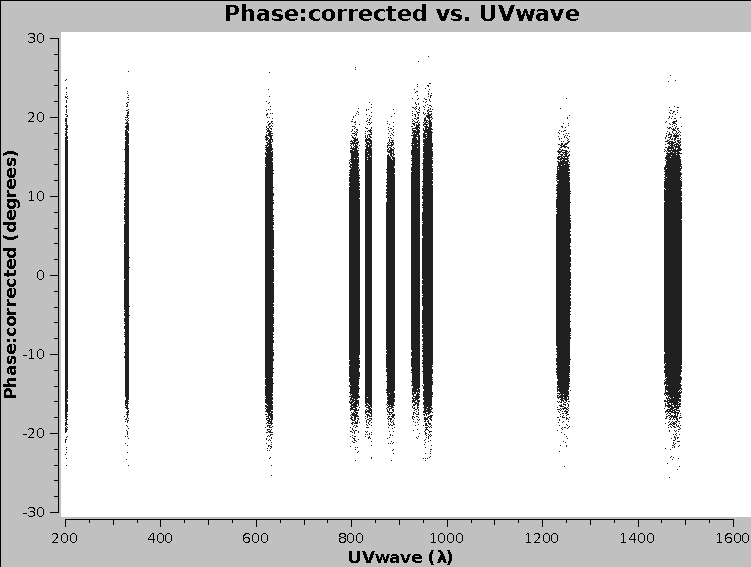

True

Show log 2019-08-22 14:20:48	INFO	plotms::::	
 2019-08-22 14:20:48	INFO	plotms::::+	##########################################
 2019-08-22 14:20:48	INFO	plotms::::+	##### Begin Task: plotms #####
 2019-08-22 14:20:48	INFO	plotms::::	plotms(vis="ngc3621_fixvis.ms",gridrows=1,gridcols=1,rowindex=0,colindex=0,
 2019-08-22 14:20:48	INFO	plotms::::+ plotindex=0,xaxis="uvwave",xdatacolumn="",xframe="",xinterp="",
 2019-08-22 14:20:48	INFO	plotms::::+ yaxis="phase",ydatacolumn="corrected",yframe="",yinterp="",yaxislocation="",
 2019-08-22 14:20:48	INFO	plotms::::+ selectdata=True,field="0408-65",spw="",timerange="",uvrange="",
 2019-08-22 14:20:48	INFO	plotms::::+ antenna="",scan="",correlation="XX,YY",array="",observation="",
 2019-08-22 14:20:48	INFO	plotms::::+ intent="",feed="",msselect="",averagedata=True,avgchannel="",
 2019-08-22 14:20:48	INFO	plotms::::+ avgtime="",avgscan=False,avgfield=False,avgbaseline=False,avgantenna=False,
 2019-08-22 14:20:48	INFO	plotms::::+ avgspw=False,scalar=False,transform=True,freqframe="",restfreq="",
 2019-08-22 14:20:48	INFO	plotms::::+ veldef="RADIO",shift=[0.0, 0.0],extendflag=False,extcorr=False,extchannel=False,
 2019-08-22 14:20:48	INFO	plotms::::+ iteraxis="",xselfscale=False,yselfscale=False,xsharedaxis=False,ysharedaxis=False,
 2019-08-22 14:20:48	INFO	plotms::::+ customsymbol=False,symbolshape="autoscaling",symbolsize=2,symbolcolor="0000ff",symbolfill="fill",
 2019-08-22 14:20:48	INFO	plotms::::+ symboloutline=False,coloraxis="field",customflaggedsymbol=False,flaggedsymbolshape="circle",flaggedsymbolsize=2,
 2019-08-22 14:20:48	INFO	plotms::::+ flaggedsymbolcolor="ff0000",flaggedsymbolfill="fill",flaggedsymboloutline=False,xconnector="",timeconnector=False,
 2019-08-22 14:20:48	INFO	plotms::::+ plotrange=[],title="",titlefont=0,xlabel="",xaxisfont=0,
 2019-08-22 14:20:48	INFO	plotms::::+ ylabel="",yaxisfont=0,showmajorgrid=False,majorwidth=1,majorstyle="",
 2019-08-22 14:20:48	INFO	plotms::::+ majorcolor="B0B0B0",showminorgrid=False,minorwidth=1,minorstyle="",minorcolor="D0D0D0",
 2019-08-22 14:20:48	INFO	plotms::::+ showlegend=False,legendposition="",plotfile="plotms_temp.png",expformat="",verbose=True,
 2019-08-22 14:20:48	INFO	plotms::::+ exprange="",highres=False,dpi=-1,width=-1,height=-1,
 2019-08-22 14:20:48	INFO	plotms::::+ overwrite=True,showgui=False,clearplots=True,callib=[''],headeritems="",
 2019-08-22 14:20:48	INFO	plotms::::+ showatm=False,showtsky=False)
 2019-08-22 14:20:48	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2019-08-22 14:20:48	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2019-08-22 14:20:48	INFO	PlotMS::load_cache	START Current memory usage: 5689.84 kilobytes.
 2019-08-22 14:20:48	INFO	PlotMS::load_cache	Plot Data Transformations:
 2019-08-22 14:20:48	INFO	PlotMS::load_cache+ Frame = 
 2019-08-22 14:20:48	INFO	PlotMS::load_cache+ VelDef = RADIO
 2019-08-22 14:20:48	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2019-08-22 14:20:48	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2019-08-22 14:20:48	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2019-08-22 14:20:48	INFO	PlotMS::load_cache+ formStokes = false
 2019-08-22 14:20:48	INFO	PlotMS::load_cache	Data Averaging: None.
 2019-08-22 14:20:48	INFO	PlotMS::load_cache	Plot Data Calibration:
 2019-08-22 14:20:48	INFO	PlotMS::load_cache+ Use Calibration = 0
 2019-08-22 14:20:48	INFO	PlotMS::load_cache+ Calibration Library = 
 2019-08-22 14:20:48	INFO	PlotMS::load_cache	Caching for the new plot: Phase(18):corrected vs. UVwave(29)...
 2019-08-22 14:20:48	INFO	PlotMS::load_cache	Loading page header cache
 2019-08-22 14:20:48	INFO	PlotMS::load_cache	Data selection will yield a total of 5632200 plottable points (flagged and unflagged).
 2019-08-22 14:20:48	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0579741 GB of memory (10.2933 bytes/point).
 2019-08-22 14:20:48	INFO	PlotMS::load_cache+	This is 0.355385% of the

In [44]:
plotms(vis=msfile,
       field=fluxcal,
       xaxis='uvwave',
       yaxis='phase',
       correlation='XX,YY',
       ydatacolumn='corrected',
       coloraxis = 'field')

This example does not have cross correlation products. To view the products:
```
plotms(vis=msfile,
       field=fluxcal,
       xaxis='imag',
       yaxis='real',
       correlation='XY,YX',
       xdatacolumn='corrected',
       ydatacolumn='corrected',
       coloraxis = 'corr')
```

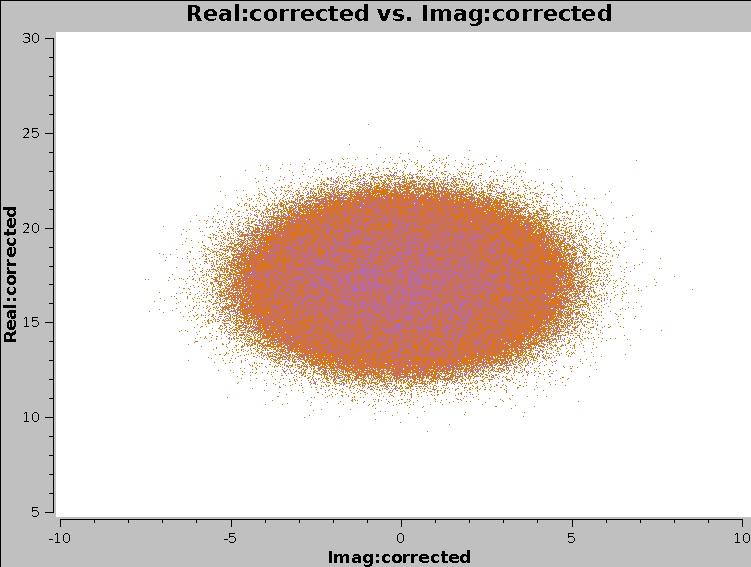

True

Show log 2019-08-22 14:47:14	INFO	plotms::::	
 2019-08-22 14:47:14	INFO	plotms::::+	##########################################
 2019-08-22 14:47:14	INFO	plotms::::+	##### Begin Task: plotms #####
 2019-08-22 14:47:14	INFO	plotms::::	plotms(vis="ngc3621_fixvis.ms",gridrows=1,gridcols=1,rowindex=0,colindex=0,
 2019-08-22 14:47:14	INFO	plotms::::+ plotindex=0,xaxis="imag",xdatacolumn="corrected",xframe="",xinterp="",
 2019-08-22 14:47:14	INFO	plotms::::+ yaxis="real",ydatacolumn="corrected",yframe="",yinterp="",yaxislocation="",
 2019-08-22 14:47:14	INFO	plotms::::+ selectdata=True,field="0408-65",spw="",timerange="",uvrange="",
 2019-08-22 14:47:14	INFO	plotms::::+ antenna="",scan="",correlation="XX,YY",array="",observation="",
 2019-08-22 14:47:14	INFO	plotms::::+ intent="",feed="",msselect="",averagedata=True,avgchannel="",
 2019-08-22 14:47:14	INFO	plotms::::+ avgtime="",avgscan=False,avgfield=False,avgbaseline=False,avgantenna=False,
 2019-08-22 14:47:14	INFO	plotms::::+ avgspw=False,scalar=False,transform=True,freqframe="",restfreq="",
 2019-08-22 14:47:14	INFO	plotms::::+ veldef="RADIO",shift=[0.0, 0.0],extendflag=False,extcorr=False,extchannel=False,
 2019-08-22 14:47:14	INFO	plotms::::+ iteraxis="",xselfscale=False,yselfscale=False,xsharedaxis=False,ysharedaxis=False,
 2019-08-22 14:47:14	INFO	plotms::::+ customsymbol=False,symbolshape="autoscaling",symbolsize=2,symbolcolor="0000ff",symbolfill="fill",
 2019-08-22 14:47:14	INFO	plotms::::+ symboloutline=False,coloraxis="corr",customflaggedsymbol=False,flaggedsymbolshape="circle",flaggedsymbolsize=2,
 2019-08-22 14:47:14	INFO	plotms::::+ flaggedsymbolcolor="ff0000",flaggedsymbolfill="fill",flaggedsymboloutline=False,xconnector="",timeconnector=False,
 2019-08-22 14:47:14	INFO	plotms::::+ plotrange=[],title="",titlefont=0,xlabel="",xaxisfont=0,
 2019-08-22 14:47:14	INFO	plotms::::+ ylabel="",yaxisfont=0,showmajorgrid=False,majorwidth=1,majorstyle="",
 2019-08-22 14:47:14	INFO	plotms::::+ majorcolor="B0B0B0",showminorgrid=False,minorwidth=1,minorstyle="",minorcolor="D0D0D0",
 2019-08-22 14:47:14	INFO	plotms::::+ showlegend=False,legendposition="",plotfile="plotms_temp.png",expformat="",verbose=True,
 2019-08-22 14:47:14	INFO	plotms::::+ exprange="",highres=False,dpi=-1,width=-1,height=-1,
 2019-08-22 14:47:14	INFO	plotms::::+ overwrite=True,showgui=False,clearplots=True,callib=[''],headeritems="",
 2019-08-22 14:47:14	INFO	plotms::::+ showatm=False,showtsky=False)
 2019-08-22 14:47:14	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2019-08-22 14:47:14	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2019-08-22 14:47:14	INFO	PlotMS::load_cache	START Current memory usage: 5733.42 kilobytes.
 2019-08-22 14:47:14	INFO	PlotMS::load_cache	Plot Data Transformations:
 2019-08-22 14:47:14	INFO	PlotMS::load_cache+ Frame = 
 2019-08-22 14:47:14	INFO	PlotMS::load_cache+ VelDef = RADIO
 2019-08-22 14:47:14	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2019-08-22 14:47:14	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2019-08-22 14:47:14	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2019-08-22 14:47:14	INFO	PlotMS::load_cache+ formStokes = false
 2019-08-22 14:47:14	INFO	PlotMS::load_cache	Data Averaging: None.
 2019-08-22 14:47:14	INFO	PlotMS::load_cache	Plot Data Calibration:
 2019-08-22 14:47:14	INFO	PlotMS::load_cache+ Use Calibration = 0
 2019-08-22 14:47:14	INFO	PlotMS::load_cache+ Calibration Library = 
 2019-08-22 14:47:14	INFO	PlotMS::load_cache	Caching for the new plot: Real(19):corrected vs. Imag(20):corrected...
 2019-08-22 14:47:14	INFO	PlotMS::load_cache	Loading page header cache
 2019-08-22 14:47:14	INFO	PlotMS::load_cache	Data selection will yield a total of 5632200 plottable points (flagged and unflagged).
 2019-08-22 14:47:14	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0579741 GB of memory (10.2933 bytes/point).
 2019-08-22 14:47:14	INFO	PlotMS::load_cache+	This is 0.35

In [48]:
plotms(vis=msfile,
       field=fluxcal,
       xaxis='imag',
       yaxis='real',
       correlation='XX,YY',
       xdatacolumn='corrected',
       ydatacolumn='corrected',
       coloraxis = 'corr')

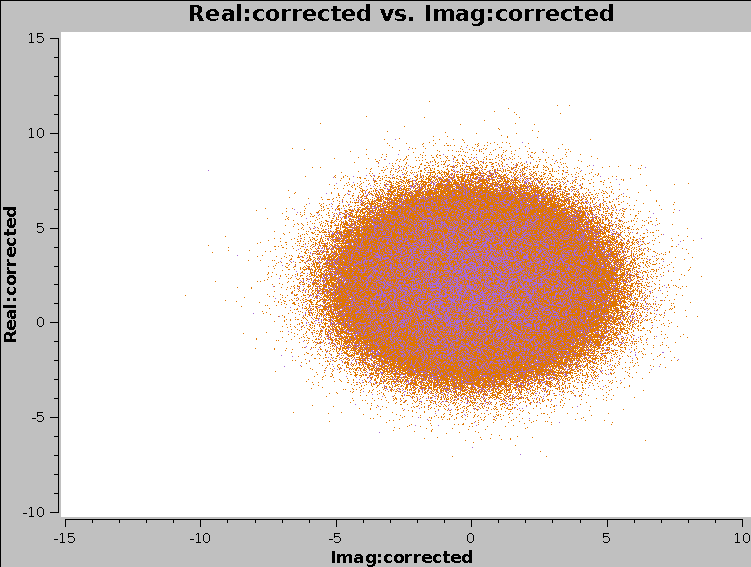

True

Show log 2019-08-22 14:47:26	INFO	plotms::::	
 2019-08-22 14:47:26	INFO	plotms::::+	##########################################
 2019-08-22 14:47:26	INFO	plotms::::+	##### Begin Task: plotms #####
 2019-08-22 14:47:26	INFO	plotms::::	plotms(vis="ngc3621_fixvis.ms",gridrows=1,gridcols=1,rowindex=0,colindex=0,
 2019-08-22 14:47:26	INFO	plotms::::+ plotindex=0,xaxis="imag",xdatacolumn="corrected",xframe="",xinterp="",
 2019-08-22 14:47:26	INFO	plotms::::+ yaxis="real",ydatacolumn="corrected",yframe="",yinterp="",yaxislocation="",
 2019-08-22 14:47:26	INFO	plotms::::+ selectdata=True,field="1117-248",spw="",timerange="",uvrange="",
 2019-08-22 14:47:26	INFO	plotms::::+ antenna="",scan="",correlation="XX,YY",array="",observation="",
 2019-08-22 14:47:26	INFO	plotms::::+ intent="",feed="",msselect="",averagedata=True,avgchannel="",
 2019-08-22 14:47:26	INFO	plotms::::+ avgtime="",avgscan=False,avgfield=False,avgbaseline=False,avgantenna=False,
 2019-08-22 14:47:26	INFO	plotms::::+ avgspw=False,scalar=False,transform=True,freqframe="",restfreq="",
 2019-08-22 14:47:26	INFO	plotms::::+ veldef="RADIO",shift=[0.0, 0.0],extendflag=False,extcorr=False,extchannel=False,
 2019-08-22 14:47:26	INFO	plotms::::+ iteraxis="",xselfscale=False,yselfscale=False,xsharedaxis=False,ysharedaxis=False,
 2019-08-22 14:47:26	INFO	plotms::::+ customsymbol=False,symbolshape="autoscaling",symbolsize=2,symbolcolor="0000ff",symbolfill="fill",
 2019-08-22 14:47:26	INFO	plotms::::+ symboloutline=False,coloraxis="corr",customflaggedsymbol=False,flaggedsymbolshape="circle",flaggedsymbolsize=2,
 2019-08-22 14:47:26	INFO	plotms::::+ flaggedsymbolcolor="ff0000",flaggedsymbolfill="fill",flaggedsymboloutline=False,xconnector="",timeconnector=False,
 2019-08-22 14:47:26	INFO	plotms::::+ plotrange=[],title="",titlefont=0,xlabel="",xaxisfont=0,
 2019-08-22 14:47:26	INFO	plotms::::+ ylabel="",yaxisfont=0,showmajorgrid=False,majorwidth=1,majorstyle="",
 2019-08-22 14:47:26	INFO	plotms::::+ majorcolor="B0B0B0",showminorgrid=False,minorwidth=1,minorstyle="",minorcolor="D0D0D0",
 2019-08-22 14:47:26	INFO	plotms::::+ showlegend=False,legendposition="",plotfile="plotms_temp.png",expformat="",verbose=True,
 2019-08-22 14:47:26	INFO	plotms::::+ exprange="",highres=False,dpi=-1,width=-1,height=-1,
 2019-08-22 14:47:26	INFO	plotms::::+ overwrite=True,showgui=False,clearplots=True,callib=[''],headeritems="",
 2019-08-22 14:47:26	INFO	plotms::::+ showatm=False,showtsky=False)
 2019-08-22 14:47:27	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2019-08-22 14:47:27	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2019-08-22 14:47:27	INFO	PlotMS::load_cache	START Current memory usage: 5744.44 kilobytes.
 2019-08-22 14:47:27	INFO	PlotMS::load_cache	Plot Data Transformations:
 2019-08-22 14:47:27	INFO	PlotMS::load_cache+ Frame = 
 2019-08-22 14:47:27	INFO	PlotMS::load_cache+ VelDef = RADIO
 2019-08-22 14:47:27	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2019-08-22 14:47:27	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2019-08-22 14:47:27	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2019-08-22 14:47:27	INFO	PlotMS::load_cache+ formStokes = false
 2019-08-22 14:47:27	INFO	PlotMS::load_cache	Data Averaging: None.
 2019-08-22 14:47:27	INFO	PlotMS::load_cache	Plot Data Calibration:
 2019-08-22 14:47:27	INFO	PlotMS::load_cache+ Use Calibration = 0
 2019-08-22 14:47:27	INFO	PlotMS::load_cache+ Calibration Library = 
 2019-08-22 14:47:27	INFO	PlotMS::load_cache	Caching for the new plot: Real(19):corrected vs. Imag(20):corrected...
 2019-08-22 14:47:27	INFO	PlotMS::load_cache	Loading page header cache
 2019-08-22 14:47:27	INFO	PlotMS::load_cache	Data selection will yield a total of 5594400 plottable points (flagged and unflagged).
 2019-08-22 14:47:27	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.057585 GB of memory (10.2933 bytes/point).
 2019-08-22 14:47:27	INFO	PlotMS::load_cache+	This is 0.35

In [49]:
plotms(vis=msfile,
       field=phasecal,
       xaxis='imag',
       yaxis='real',
       correlation='XX,YY',
       xdatacolumn='corrected',
       ydatacolumn='corrected',
       coloraxis = 'corr')

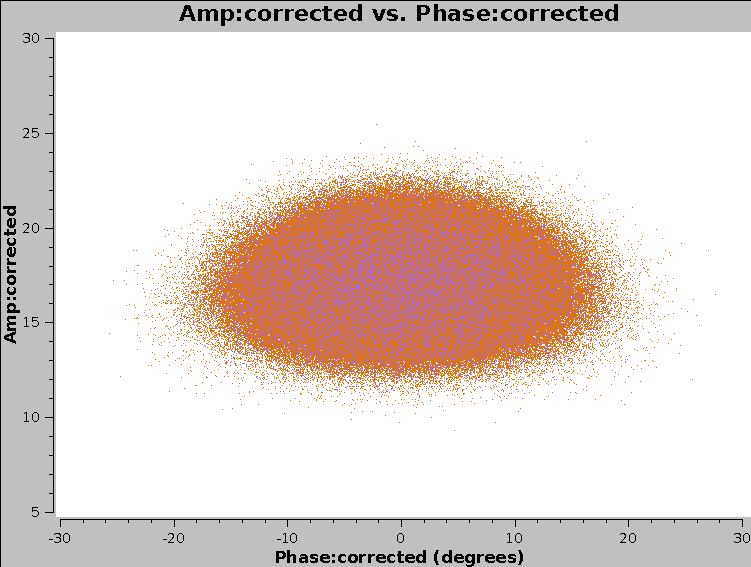

True

Show log 2019-08-22 14:48:45	INFO	plotms::::	
 2019-08-22 14:48:45	INFO	plotms::::+	##########################################
 2019-08-22 14:48:45	INFO	plotms::::+	##### Begin Task: plotms #####
 2019-08-22 14:48:45	INFO	plotms::::	plotms(vis="ngc3621_fixvis.ms",gridrows=1,gridcols=1,rowindex=0,colindex=0,
 2019-08-22 14:48:45	INFO	plotms::::+ plotindex=0,xaxis="phase",xdatacolumn="corrected",xframe="",xinterp="",
 2019-08-22 14:48:45	INFO	plotms::::+ yaxis="amp",ydatacolumn="corrected",yframe="",yinterp="",yaxislocation="",
 2019-08-22 14:48:45	INFO	plotms::::+ selectdata=True,field="0408-65",spw="",timerange="",uvrange="",
 2019-08-22 14:48:45	INFO	plotms::::+ antenna="",scan="",correlation="XX,YY",array="",observation="",
 2019-08-22 14:48:45	INFO	plotms::::+ intent="",feed="",msselect="",averagedata=True,avgchannel="",
 2019-08-22 14:48:45	INFO	plotms::::+ avgtime="",avgscan=False,avgfield=False,avgbaseline=False,avgantenna=False,
 2019-08-22 14:48:45	INFO	plotms::::+ avgspw=False,scalar=False,transform=True,freqframe="",restfreq="",
 2019-08-22 14:48:45	INFO	plotms::::+ veldef="RADIO",shift=[0.0, 0.0],extendflag=False,extcorr=False,extchannel=False,
 2019-08-22 14:48:45	INFO	plotms::::+ iteraxis="",xselfscale=False,yselfscale=False,xsharedaxis=False,ysharedaxis=False,
 2019-08-22 14:48:45	INFO	plotms::::+ customsymbol=False,symbolshape="autoscaling",symbolsize=2,symbolcolor="0000ff",symbolfill="fill",
 2019-08-22 14:48:45	INFO	plotms::::+ symboloutline=False,coloraxis="corr",customflaggedsymbol=False,flaggedsymbolshape="circle",flaggedsymbolsize=2,
 2019-08-22 14:48:45	INFO	plotms::::+ flaggedsymbolcolor="ff0000",flaggedsymbolfill="fill",flaggedsymboloutline=False,xconnector="",timeconnector=False,
 2019-08-22 14:48:45	INFO	plotms::::+ plotrange=[],title="",titlefont=0,xlabel="",xaxisfont=0,
 2019-08-22 14:48:45	INFO	plotms::::+ ylabel="",yaxisfont=0,showmajorgrid=False,majorwidth=1,majorstyle="",
 2019-08-22 14:48:45	INFO	plotms::::+ majorcolor="B0B0B0",showminorgrid=False,minorwidth=1,minorstyle="",minorcolor="D0D0D0",
 2019-08-22 14:48:45	INFO	plotms::::+ showlegend=False,legendposition="",plotfile="plotms_temp.png",expformat="",verbose=True,
 2019-08-22 14:48:45	INFO	plotms::::+ exprange="",highres=False,dpi=-1,width=-1,height=-1,
 2019-08-22 14:48:45	INFO	plotms::::+ overwrite=True,showgui=False,clearplots=True,callib=[''],headeritems="",
 2019-08-22 14:48:45	INFO	plotms::::+ showatm=False,showtsky=False)
 2019-08-22 14:48:45	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2019-08-22 14:48:45	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2019-08-22 14:48:45	INFO	PlotMS::load_cache	START Current memory usage: 5762.72 kilobytes.
 2019-08-22 14:48:45	INFO	PlotMS::load_cache	Plot Data Transformations:
 2019-08-22 14:48:45	INFO	PlotMS::load_cache+ Frame = 
 2019-08-22 14:48:45	INFO	PlotMS::load_cache+ VelDef = RADIO
 2019-08-22 14:48:45	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2019-08-22 14:48:45	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2019-08-22 14:48:45	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2019-08-22 14:48:45	INFO	PlotMS::load_cache+ formStokes = false
 2019-08-22 14:48:45	INFO	PlotMS::load_cache	Data Averaging: None.
 2019-08-22 14:48:45	INFO	PlotMS::load_cache	Plot Data Calibration:
 2019-08-22 14:48:45	INFO	PlotMS::load_cache+ Use Calibration = 0
 2019-08-22 14:48:45	INFO	PlotMS::load_cache+ Calibration Library = 
 2019-08-22 14:48:45	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17):corrected vs. Phase(18):corrected...
 2019-08-22 14:48:45	INFO	PlotMS::load_cache	Loading page header cache
 2019-08-22 14:48:45	INFO	PlotMS::load_cache	Data selection will yield a total of 5632200 plottable points (flagged and unflagged).
 2019-08-22 14:48:45	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0579741 GB of memory (10.2933 bytes/point).
 2019-08-22 14:48:45	INFO	PlotMS::load_cache+	This is 0.35

In [51]:
plotms(vis=msfile,
       field=fluxcal,
       xaxis='phase',
       yaxis='amp',
       correlation='XX,YY',
       xdatacolumn='corrected',
       ydatacolumn='corrected',
       coloraxis = 'corr')

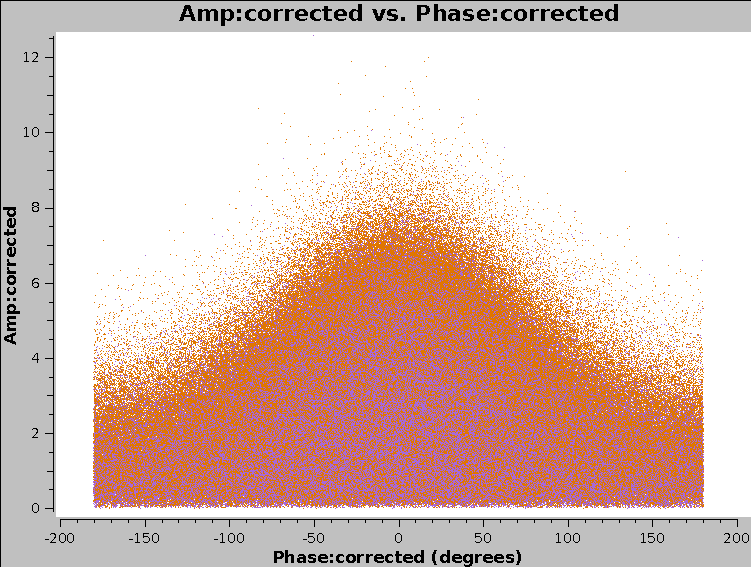

True

Show log 2019-08-22 14:50:45	INFO	plotms::::	
 2019-08-22 14:50:45	INFO	plotms::::+	##########################################
 2019-08-22 14:50:45	INFO	plotms::::+	##### Begin Task: plotms #####
 2019-08-22 14:50:45	INFO	plotms::::	plotms(vis="ngc3621_fixvis.ms",gridrows=1,gridcols=1,rowindex=0,colindex=0,
 2019-08-22 14:50:45	INFO	plotms::::+ plotindex=0,xaxis="phase",xdatacolumn="corrected",xframe="",xinterp="",
 2019-08-22 14:50:45	INFO	plotms::::+ yaxis="amp",ydatacolumn="corrected",yframe="",yinterp="",yaxislocation="",
 2019-08-22 14:50:45	INFO	plotms::::+ selectdata=True,field="1117-248",spw="",timerange="",uvrange="",
 2019-08-22 14:50:45	INFO	plotms::::+ antenna="",scan="",correlation="XX,YY",array="",observation="",
 2019-08-22 14:50:45	INFO	plotms::::+ intent="",feed="",msselect="",averagedata=True,avgchannel="",
 2019-08-22 14:50:45	INFO	plotms::::+ avgtime="",avgscan=False,avgfield=False,avgbaseline=False,avgantenna=False,
 2019-08-22 14:50:45	INFO	plotms::::+ avgspw=False,scalar=False,transform=True,freqframe="",restfreq="",
 2019-08-22 14:50:45	INFO	plotms::::+ veldef="RADIO",shift=[0.0, 0.0],extendflag=False,extcorr=False,extchannel=False,
 2019-08-22 14:50:45	INFO	plotms::::+ iteraxis="",xselfscale=False,yselfscale=False,xsharedaxis=False,ysharedaxis=False,
 2019-08-22 14:50:45	INFO	plotms::::+ customsymbol=False,symbolshape="autoscaling",symbolsize=2,symbolcolor="0000ff",symbolfill="fill",
 2019-08-22 14:50:45	INFO	plotms::::+ symboloutline=False,coloraxis="corr",customflaggedsymbol=False,flaggedsymbolshape="circle",flaggedsymbolsize=2,
 2019-08-22 14:50:45	INFO	plotms::::+ flaggedsymbolcolor="ff0000",flaggedsymbolfill="fill",flaggedsymboloutline=False,xconnector="",timeconnector=False,
 2019-08-22 14:50:45	INFO	plotms::::+ plotrange=[],title="",titlefont=0,xlabel="",xaxisfont=0,
 2019-08-22 14:50:45	INFO	plotms::::+ ylabel="",yaxisfont=0,showmajorgrid=False,majorwidth=1,majorstyle="",
 2019-08-22 14:50:45	INFO	plotms::::+ majorcolor="B0B0B0",showminorgrid=False,minorwidth=1,minorstyle="",minorcolor="D0D0D0",
 2019-08-22 14:50:45	INFO	plotms::::+ showlegend=False,legendposition="",plotfile="plotms_temp.png",expformat="",verbose=True,
 2019-08-22 14:50:45	INFO	plotms::::+ exprange="",highres=False,dpi=-1,width=-1,height=-1,
 2019-08-22 14:50:45	INFO	plotms::::+ overwrite=True,showgui=False,clearplots=True,callib=[''],headeritems="",
 2019-08-22 14:50:45	INFO	plotms::::+ showatm=False,showtsky=False)
 2019-08-22 14:50:45	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2019-08-22 14:50:45	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2019-08-22 14:50:45	INFO	PlotMS::load_cache	START Current memory usage: 5800.73 kilobytes.
 2019-08-22 14:50:45	INFO	PlotMS::load_cache	Plot Data Transformations:
 2019-08-22 14:50:45	INFO	PlotMS::load_cache+ Frame = 
 2019-08-22 14:50:45	INFO	PlotMS::load_cache+ VelDef = RADIO
 2019-08-22 14:50:45	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2019-08-22 14:50:45	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2019-08-22 14:50:45	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2019-08-22 14:50:45	INFO	PlotMS::load_cache+ formStokes = false
 2019-08-22 14:50:45	INFO	PlotMS::load_cache	Data Averaging: None.
 2019-08-22 14:50:45	INFO	PlotMS::load_cache	Plot Data Calibration:
 2019-08-22 14:50:45	INFO	PlotMS::load_cache+ Use Calibration = 0
 2019-08-22 14:50:45	INFO	PlotMS::load_cache+ Calibration Library = 
 2019-08-22 14:50:45	INFO	PlotMS::load_cache	Caching for the new plot: Amp(17):corrected vs. Phase(18):corrected...
 2019-08-22 14:50:45	INFO	PlotMS::load_cache	Loading page header cache
 2019-08-22 14:50:46	INFO	PlotMS::load_cache	Data selection will yield a total of 5594400 plottable points (flagged and unflagged).
 2019-08-22 14:50:46	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.057585 GB of memory (10.2933 bytes/point).
 2019-08-22 14:50:46	INFO	PlotMS::load_cache+	This is 0.35

In [54]:
plotms(vis=msfile,
       field=phasecal,
       xaxis='phase',
       yaxis='amp',
       correlation='XX,YY',
       xdatacolumn='corrected',
       ydatacolumn='corrected',
       coloraxis = 'corr')

If required preform flagging after calibration -- inspect data with plotms, flag target and re-apply calibration

If all looks well, apply cal to target

In [38]:
print('---> Applycal: {}'.format(target))
applycal(vis=msfile,
         field=target,
         gaintable=[ftable, btable, ktable],
         gainfield=[phasecal, '', ''],
         interp=['', 'nearest', ''],
         calwt=False,
         applymode='calflag')

---> Applycal: NGC3621


Show log 2019-08-22 14:17:45	INFO	applycal::::	
 2019-08-22 14:17:45	INFO	applycal::::+	##########################################
 2019-08-22 14:17:45	INFO	applycal::::+	##### Begin Task: applycal #####
 2019-08-22 14:17:45	INFO	applycal::::	applycal(vis="ngc3621_fixvis.ms",field="NGC3621",spw="",intent="",selectdata=True,
 2019-08-22 14:17:45	INFO	applycal::::+ timerange="",uvrange="",antenna="",scan="",observation="",
 2019-08-22 14:17:45	INFO	applycal::::+ msselect="",docallib=False,callib="",gaintable=['ngc3621.flux', 'ngc3621.B', 'ngc3621.K'],gainfield=['1117-248', '', ''],
 2019-08-22 14:17:45	INFO	applycal::::+ interp=['', 'nearest', ''],spwmap=[],calwt=False,parang=False,applymode="calflag",
 2019-08-22 14:17:45	INFO	applycal::::+ flagbackup=True)
 2019-08-22 14:17:45	INFO	applycal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-08-22 14:17:45	INFO	applycal::calibrater::open	Opening MS: ngc3621_fixvis.ms for calibration.
 2019-08-22 14:17:45	INFO	applycal::Calibrater::	Initializing nominal selection to the whole MS.
 2019-08-22 14:17:45	INFO	applycal::AgentFlagger::open	Table type is Measurement Set
 2019-08-22 14:17:45	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called applycal_4
 2019-08-22 14:17:45	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-08-22 14:17:45	INFO	calibrater::reset	Reseting solve/apply state
 2019-08-22 14:17:45	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2019-08-22 14:17:45	INFO	Calibrater::selectvis+ Selecting on field: 'NGC3621'
 2019-08-22 14:17:45	INFO	Calibrater::selectvis	By selection 15687 rows are reduced to 9450
 2019-08-22 14:17:45	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2019-08-22 14:17:45	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2019-08-22 14:17:45	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:17:45	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:17:45	INFO	Calibrater::setapply(type, applypar)	. G Jones: table=ngc3621.flux select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:45	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:17:45	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:17:45	INFO	Calibrater::setapply(type, applypar)	. B Jones: table=ngc3621.B select= interp=nearest,linear spwmap=[-1] calWt=false
 2019-08-22 14:17:45	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-08-22 14:17:45	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-08-22 14:17:45	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:45	INFO	calibrater::correct	Beginning correct---------------------------
 2019-08-22 14:17:45	INFO	Calibrater::correct2 (VI2/VB2)	The following calibration terms are arranged for apply:
 2019-08-22 14:17:45	INFO	Calibrater::correct2 (VI2/VB2)	. B Jones: table=ngc3621.B select= interp=nearest,linear spwmap=[-1] calWt=false
 2019-08-22 14:17:45	INFO	Calibrater::correct2 (VI2/VB2)	. K Jones: table=ngc3621.K select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:45	INFO	Calibrater::correct2 (VI2/VB2)	. G Jones: table=ngc3621.flux select= interp=linear spwmap=[-1] calWt=false
 2019-08-22 14:17:47	INFO	calibrater::correct	Finished correcting.
 2019-08-22 14:17:47	INFO	applycal::::	Calibration apply flagging statistics (among calibrateable spws):
 2019-08-22 14:17:47	INFO	applycal:::: Total visibilities selected for correction (ncorr x nchan x nrow summed over spws) = 17010000
 2019-08-22 14:17:47	INFO	applycal:::: Flags:
 2019-08-22 14:17:47	INFO	applycal:::: B Jones: In: 8910000 / 17010000 (52.380952381%) --> Out: 8910000 / 17010000 (52.380952381%) (ngc3621.B)
 2019-08-22 14:17:47	INFO	applycal:::: K 

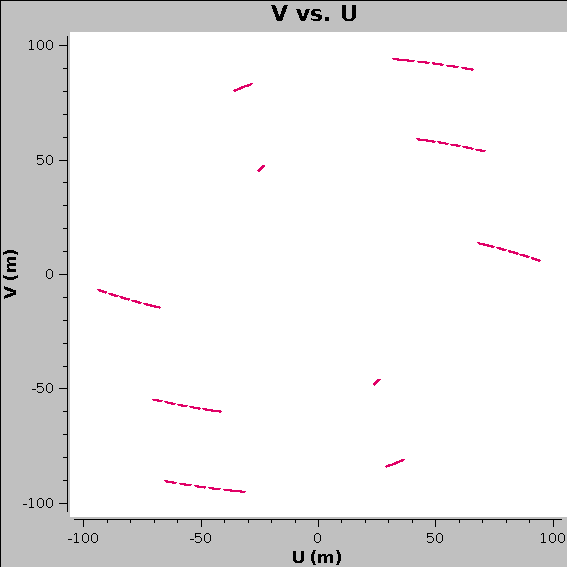

True

Show log 2019-08-22 14:51:57	INFO	plotms::::	
 2019-08-22 14:51:57	INFO	plotms::::+	##########################################
 2019-08-22 14:51:57	INFO	plotms::::+	##### Begin Task: plotms #####
 2019-08-22 14:51:57	INFO	plotms::::	plotms(vis="ngc3621_fixvis.ms",gridrows=1,gridcols=1,rowindex=0,colindex=0,
 2019-08-22 14:51:57	INFO	plotms::::+ plotindex=0,xaxis="u",xdatacolumn="",xframe="",xinterp="",
 2019-08-22 14:51:57	INFO	plotms::::+ yaxis="v",ydatacolumn="corrected",yframe="",yinterp="",yaxislocation="",
 2019-08-22 14:51:57	INFO	plotms::::+ selectdata=True,field="NGC3621",spw="",timerange="",uvrange="",
 2019-08-22 14:51:57	INFO	plotms::::+ antenna="",scan="",correlation="",array="",observation="",
 2019-08-22 14:51:57	INFO	plotms::::+ intent="",feed="",msselect="",averagedata=True,avgchannel="",
 2019-08-22 14:51:57	INFO	plotms::::+ avgtime="",avgscan=False,avgfield=False,avgbaseline=False,avgantenna=False,
 2019-08-22 14:51:57	INFO	plotms::::+ avgspw=False,scalar=False,transform=True,freqframe="",restfreq="",
 2019-08-22 14:51:57	INFO	plotms::::+ veldef="RADIO",shift=[0.0, 0.0],extendflag=False,extcorr=False,extchannel=False,
 2019-08-22 14:51:57	INFO	plotms::::+ iteraxis="",xselfscale=False,yselfscale=False,xsharedaxis=False,ysharedaxis=False,
 2019-08-22 14:51:57	INFO	plotms::::+ customsymbol=False,symbolshape="autoscaling",symbolsize=2,symbolcolor="0000ff",symbolfill="fill",
 2019-08-22 14:51:57	INFO	plotms::::+ symboloutline=False,coloraxis="field",customflaggedsymbol=False,flaggedsymbolshape="circle",flaggedsymbolsize=2,
 2019-08-22 14:51:57	INFO	plotms::::+ flaggedsymbolcolor="ff0000",flaggedsymbolfill="fill",flaggedsymboloutline=False,xconnector="",timeconnector=False,
 2019-08-22 14:51:57	INFO	plotms::::+ plotrange=[],title="",titlefont=0,xlabel="",xaxisfont=0,
 2019-08-22 14:51:57	INFO	plotms::::+ ylabel="",yaxisfont=0,showmajorgrid=False,majorwidth=1,majorstyle="",
 2019-08-22 14:51:57	INFO	plotms::::+ majorcolor="B0B0B0",showminorgrid=False,minorwidth=1,minorstyle="",minorcolor="D0D0D0",
 2019-08-22 14:51:57	INFO	plotms::::+ showlegend=False,legendposition="",plotfile="plotms_temp.png",expformat="",verbose=True,
 2019-08-22 14:51:57	INFO	plotms::::+ exprange="",highres=False,dpi=-1,width=-1,height=-1,
 2019-08-22 14:51:57	INFO	plotms::::+ overwrite=True,showgui=False,clearplots=True,callib=[''],headeritems="",
 2019-08-22 14:51:57	INFO	plotms::::+ showatm=False,showtsky=False)
 2019-08-22 14:51:57	INFO	PlotMS::params_changed	Updating: REDRAW, MSDATA, CACHE, AXES, CANVAS, DISPLAY, PAGEHEADER, ITERATION, LOG, PLOTMS_OPTIONS.
 2019-08-22 14:51:57	INFO	PlotMS::load_cache	Clearing the existing plotms cache.
 2019-08-22 14:51:57	INFO	PlotMS::load_cache	START Current memory usage: 5812.56 kilobytes.
 2019-08-22 14:51:57	INFO	PlotMS::load_cache	Plot Data Transformations:
 2019-08-22 14:51:57	INFO	PlotMS::load_cache+ Frame = 
 2019-08-22 14:51:57	INFO	PlotMS::load_cache+ VelDef = RADIO
 2019-08-22 14:51:57	INFO	PlotMS::load_cache+ RestFreq = 0 MHz
 2019-08-22 14:51:57	INFO	PlotMS::load_cache+ dX = 0 arcsec
 2019-08-22 14:51:57	INFO	PlotMS::load_cache+ dY = 0 arcsec
 2019-08-22 14:51:57	INFO	PlotMS::load_cache+ formStokes = false
 2019-08-22 14:51:57	INFO	PlotMS::load_cache	Data Averaging: None.
 2019-08-22 14:51:57	INFO	PlotMS::load_cache	Plot Data Calibration:
 2019-08-22 14:51:57	INFO	PlotMS::load_cache+ Use Calibration = 0
 2019-08-22 14:51:57	INFO	PlotMS::load_cache+ Calibration Library = 
 2019-08-22 14:51:57	INFO	PlotMS::load_cache	Caching for the new plot: V(31) vs. U(30)...
 2019-08-22 14:51:57	INFO	PlotMS::load_cache	Loading page header cache
 2019-08-22 14:51:58	INFO	PlotMS::load_cache	Data selection will yield a total of 17010000 plottable points (flagged and unflagged).
 2019-08-22 14:51:58	INFO	PlotMS::load_cache+	The plotms cache will require an estimated 0.0391608 GB of memory (2.30222 bytes/point).
 2019-08-22 14:51:58	INFO	PlotMS::load_cache+	This is 0.240058% of the memory avail. to CASA (16.3131 

In [55]:
plotms(vis=msfile,
       xaxis='u', yaxis='v',
       field=target,
       ydatacolumn='corrected', coloraxis='field', correlation='')